# Import

In [52]:
# Import necessary libraries
import yaml
import sys
sys.path.append('/sdf/data/neutrino/software/spine/src')

from spine.driver import Driver
from spine.vis import Drawer
from spine.utils.geo import Geometry

import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Import optimization libraries
from scipy.optimize import minimize, differential_evolution

# Import custom modules
if 'data_process_modules' in sys.modules:
    del sys.modules['data_process_modules']
if 'optimzation_modules' in sys.modules:
    del sys.modules['optimzation_modules']
from data_process_modules import extract_particle_features, compute_shower_dqdx, pca_analysis
import optimzation_modules as om

# Use reload to always get the latest version of the module
import importlib
importlib.reload(om)
from optimzation_modules import calculate_efficiency_purity_f1, objective_function, apply_all_cuts

%matplotlib inline

print("✓ All libraries imported successfully!")
print("✓ optimzation_modules reloaded!")

✓ All libraries imported successfully!
✓ optimzation_modules reloaded!


## Step 1: Load Data from NuOne Dataset (for Efficiency)

In [42]:
import pickle
import os

# Define data directory and file path
data_dir = '/sdf/home/l/liuty/NuEEL/upload/data'
nuone_data_file = os.path.join(data_dir, 'nuone_data_optimization.pkl')

# Create data directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Check if saved data exists
if os.path.exists(nuone_data_file):
    print("=" * 80)
    print("Loading NuOne data from saved file...")
    print("=" * 80)
    with open(nuone_data_file, 'rb') as f:
        nuone_data = pickle.load(f)
    
    total_true_1e = sum(1 for t in nuone_data['true_topology'] if t == '1e')
    print(f"\n✓ NuOne dataset loaded from file!")
    print(f"  File: {nuone_data_file}")
    print(f"  Total interactions (all true 1e): {len(nuone_data['true_topology'])}")
    print(f"  True 1e events: {total_true_1e}")
    print("=" * 80)
else:
    # Configure and load NuOne dataset from driver
    print("=" * 80)
    print("Saved data not found. Processing NuOne dataset from driver...")
    print("=" * 80)
    
    cfg_nuone = '''
base:
  verbosity: info
build:
  mode: both
  fragments: false
  particles: true
  interactions: true
  units: cm
io:
  reader:
    file_keys: DATA_PATH
    name: hdf5
'''.replace('DATA_PATH', '/sdf/data/neutrino/ndlar/spine/prod/nuone/output_spine/MicroProdN3p2_NDLAr_2E22_FHC_NuE.flow2supera.ndlarfid.singles.000024[0-9].LARCV_spine.h5')

    driver_nuone = Driver(yaml.safe_load(cfg_nuone))

    # Process NuOne data
    nuone_data = {
        'file_index': [],
        'index': [],
        'event_id': [],
        'true_id': [],
        'reco_id': [],
        'current_type': [],
        'target': [],
        'interaction_mode': [],
        'interaction_type': [],
        'true_energy': [],
        'true_topology': [],
        'true_pdg': [],
        'true_dedx_list': [],
        'true_particle_info': [],
        'true_pca_variables': [],
        'reco_vertex': [],
        'reco_topology': [],
        'reco_dedx_list': [],
        'reco_particle_info': [],
        'reco_pca_variables': [],
    }

    geo = Geometry('ndlar')

    for data in tqdm(driver_nuone):
        for truth, reco in data['interaction_matches_t2r']:
            # ONLY save true 1e events for efficiency calculation
            if truth.topology != '1e':
                continue
            
            # Truth information
            nuone_data['file_index'].append(data['file_index'])
            nuone_data['index'].append(data['index'])
            nuone_data['event_id'].append(data['run_info'].event)
            nuone_data['true_id'].append(truth.id)
            nuone_data['current_type'].append(truth.current_type)
            nuone_data['target'].append(truth.target)
            nuone_data['interaction_mode'].append(truth.interaction_mode)
            nuone_data['interaction_type'].append(truth.interaction_type)
            nuone_data['true_energy'].append(truth.energy_init)
            nuone_data['true_topology'].append(truth.topology)
            nuone_data['true_pdg'].append(truth.pdg_code)
            nuone_data['true_dedx_list'].append(compute_shower_dqdx(truth))
            
            # Truth particle info
            info = []
            points = []
            for particle in truth.particles:
                points.append(particle.points)
                info.append(extract_particle_features(particle))
            nuone_data['true_particle_info'].append(info)
            if len(points) > 0:
                points_combined = np.vstack(points)
                nuone_data['true_pca_variables'].append(pca_analysis(points_combined))
            else:
                nuone_data['true_pca_variables'].append('')
            
            # Reco information
            if reco is None:
                nuone_data['reco_id'].append('')
                nuone_data['reco_topology'].append('')
                nuone_data['reco_vertex'].append(np.array([np.nan, np.nan, np.nan]))
                nuone_data['reco_dedx_list'].append(np.nan)
                nuone_data['reco_particle_info'].append([])
                nuone_data['reco_pca_variables'].append('')
            else:
                nuone_data['reco_id'].append(reco.id)
                nuone_data['reco_topology'].append(reco.topology)
                nuone_data['reco_vertex'].append(reco.vertex)
                nuone_data['reco_dedx_list'].append(compute_shower_dqdx(reco))
                
                # Reco particle info
                info = []
                points = []
                for particle in reco.particles:
                    points.append(particle.points)
                    info.append(extract_particle_features(particle))
                nuone_data['reco_particle_info'].append(info)
                if len(points) > 0:
                    points_combined = np.vstack(points)
                    nuone_data['reco_pca_variables'].append(pca_analysis(points_combined))
                else:
                    nuone_data['reco_pca_variables'].append('')

    # Count true 1e events (should be all of them now)
    total_true_1e = sum(1 for t in nuone_data['true_topology'] if t == '1e')
    print(f"\n✓ NuOne dataset processed!")
    print(f"  Total interactions (filtered to true 1e only): {len(nuone_data['true_topology'])}")
    print(f"  True 1e events: {total_true_1e}")
    
    # Save data to file
    print(f"\nSaving data to: {nuone_data_file}")
    with open(nuone_data_file, 'wb') as f:
        pickle.dump(nuone_data, f)
    print("✓ Data saved successfully!")
    print("=" * 80)

Loading NuOne data from saved file...

✓ NuOne dataset loaded from file!
  File: /sdf/home/l/liuty/NuEEL/upload/data/nuone_data_optimization.pkl
  Total interactions (all true 1e): 6067
  True 1e events: 6067

✓ NuOne dataset loaded from file!
  File: /sdf/home/l/liuty/NuEEL/upload/data/nuone_data_optimization.pkl
  Total interactions (all true 1e): 6067
  True 1e events: 6067


## Step 2: Load Data from Full Spill Dataset (for Purity)

In [4]:
# Define file path for full spill data
full_spill_data_file = os.path.join(data_dir, 'full_spill_data_optimization.pkl')

# Check if saved data exists
if os.path.exists(full_spill_data_file):
    print("=" * 80)
    print("Loading Full Spill data from saved file...")
    print("=" * 80)
    with open(full_spill_data_file, 'rb') as f:
        full_spill_data = pickle.load(f)
    
    total_backgrounds = len(full_spill_data['reco_topology'])
    true_1e_mode7 = sum(1 for i in range(len(full_spill_data['true_topology'])) 
                        if full_spill_data['true_topology'][i] == '1e' 
                        and full_spill_data['interaction_mode'][i] == 7)
    
    print(f"\n✓ Full Spill dataset loaded from file!")
    print(f"  File: {full_spill_data_file}")
    print(f"  Total reco interactions: {total_backgrounds}")
    print(f"  True 1e (mode 7) events: {true_1e_mode7}")
    print("=" * 80)
else:
    # Configure and load Full Spill dataset from driver
    print("=" * 80)
    print("Saved data not found. Processing Full Spill dataset from driver...")
    print("=" * 80)
    
    cfg_full_spill = '''
base:
  verbosity: info
build:
  mode: both
  fragments: false
  particles: true
  interactions: true
  units: cm
io:
  reader:
    file_keys: DATA_PATH
    name: hdf5
'''.replace('DATA_PATH', '/sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.*.LARCV_spine.h5')

    driver_full_spill = Driver(yaml.safe_load(cfg_full_spill))

    # Process Full Spill data
    full_spill_data = {
        'file_index': [],
        'index': [],
        'event_id': [],
        'true_id': [],
        'reco_id': [],
        'current_type': [],
        'target': [],
        'interaction_mode': [],
        'interaction_type': [],
        'true_energy': [],
        'true_topology': [],
        'true_pdg': [],
        'true_dedx_list': [],
        'true_particle_info': [],
        'true_pca_variables': [],
        'reco_vertex': [],
        'reco_topology': [],
        'reco_dedx_list': [],
        'reco_particle_info': [],
        'reco_pca_variables': [],
    }

    for data in tqdm(driver_full_spill):
        for reco, truth in data['interaction_matches_r2t']:
            # Reco information (always present)
            full_spill_data['file_index'].append(data['file_index'])
            full_spill_data['index'].append(data['index'])
            full_spill_data['event_id'].append(data['run_info'].event)
            full_spill_data['reco_id'].append(reco.id)
            full_spill_data['reco_topology'].append(reco.topology)
            full_spill_data['reco_vertex'].append(reco.vertex)
            full_spill_data['reco_dedx_list'].append(compute_shower_dqdx(reco))
            
            # Reco particle info
            info = []
            points = []
            for particle in reco.particles:
                points.append(particle.points)
                info.append(extract_particle_features(particle))
            full_spill_data['reco_particle_info'].append(info)
            if len(points) > 0:
                points_combined = np.vstack(points)
                full_spill_data['reco_pca_variables'].append(pca_analysis(points_combined))
            else:
                full_spill_data['reco_pca_variables'].append('')
            
            # Truth information (may be None)
            if truth is None:
                full_spill_data['true_topology'].append('')
                full_spill_data['true_id'].append('')
                full_spill_data['current_type'].append('')
                full_spill_data['target'].append('')
                full_spill_data['interaction_mode'].append('')
                full_spill_data['interaction_type'].append('')
                full_spill_data['true_energy'].append('')
                full_spill_data['true_pdg'].append('')
                full_spill_data['true_particle_info'].append([])
                full_spill_data['true_dedx_list'].append('')
                full_spill_data['true_pca_variables'].append('')
            else:
                full_spill_data['true_id'].append(truth.id)
                full_spill_data['current_type'].append(truth.current_type)
                full_spill_data['target'].append(truth.target)
                full_spill_data['interaction_mode'].append(truth.interaction_mode)
                full_spill_data['interaction_type'].append(truth.interaction_type)
                full_spill_data['true_energy'].append(truth.energy_init)
                full_spill_data['true_topology'].append(truth.topology)
                full_spill_data['true_pdg'].append(truth.pdg_code)
                full_spill_data['true_dedx_list'].append(compute_shower_dqdx(truth))
                
                # Truth particle info
                info = []
                points = []
                for particle in truth.particles:
                    points.append(particle.points)
                    info.append(extract_particle_features(particle))
                full_spill_data['true_particle_info'].append(info)
                if len(points) > 0:
                    points_combined = np.vstack(points)
                    full_spill_data['true_pca_variables'].append(pca_analysis(points_combined))
                else:
                    full_spill_data['true_pca_variables'].append('')

    # Count backgrounds
    total_backgrounds = len(full_spill_data['reco_topology'])
    true_1e_mode7 = sum(1 for i in range(len(full_spill_data['true_topology'])) 
                        if full_spill_data['true_topology'][i] == '1e' 
                        and full_spill_data['interaction_mode'][i] == 7)

    print(f"\n✓ Full Spill dataset processed!")
    print(f"  Total reco interactions: {total_backgrounds}")
    print(f"  True 1e (mode 7) events: {true_1e_mode7}")
    
    # Save data to file
    print(f"\nSaving data to: {full_spill_data_file}")
    with open(full_spill_data_file, 'wb') as f:
        pickle.dump(full_spill_data, f)
    print("✓ Data saved successfully!")
    print("=" * 80)


Loading Full Spill data from saved file...

✓ Full Spill dataset loaded from file!
  File: /sdf/home/l/liuty/NuEEL/upload/data/full_spill_data_optimization.pkl
  Total reco interactions: 169325
  True 1e (mode 7) events: 3

✓ Full Spill dataset loaded from file!
  File: /sdf/home/l/liuty/NuEEL/upload/data/full_spill_data_optimization.pkl
  Total reco interactions: 169325
  True 1e (mode 7) events: 3


## Step 3: Define Optimization Parameters and Constraints

In [ ]:
# Define which cuts are enabled
enable_flags = {
    'ENABLE_TOPOLOGY_CUT': True,
    'ENABLE_FIDUCIAL_CUT': True,
    'ENABLE_ANGLE_CUT': True,
    'ENABLE_DEDX_CUT': True,
    'ENABLE_ETHETA2_CUT': True,
    'ENABLE_KE_CUT': True,
    'ENABLE_PCA_CUT': True,  # Disabled by default
    'ENABLE_PROXIMITY_CUT': True,  # Disabled by default
}

# # Initial guess (original values from cut_nuone.ipynb)
# initial_params = {
#     'MARGIN_MODULE': 1.5,
#     'MARGIN_DETECTOR': 5.0,
#     'ANGLE_CUT_MAX': 7.0,
#     'DEDX_CUT_MIN': -99999,
#     'DEDX_CUT_MAX': 2.5,
#     'ETHETA2_CUT_MAX': 3.0,
#     'KE_CUT_MIN': 150.0,
#     'PCA_TRANSVERSE_MAJOR_MIN': 0.04,
#     'PCA_TRANSVERSE_MINOR_MIN': 0.02,
#     'PROXIMITY_DISTANCE_THRESHOLD': 0.5,
# }

# Optimized parameters
initial_params = {
    'MARGIN_MODULE': 0.44,
    'MARGIN_DETECTOR': 0.0,
    'ANGLE_CUT_MAX': 7.74,
    'DEDX_CUT_MIN': -99999,
    'DEDX_CUT_MAX': 2.62,
    'ETHETA2_CUT_MAX': 5.78,
    'KE_CUT_MIN': 137.0,
    'PCA_TRANSVERSE_MAJOR_MIN': 0.0,
    'PCA_TRANSVERSE_MINOR_MIN': 0.0,
    'PROXIMITY_DISTANCE_THRESHOLD': 0.38,
}


print("\nEnabled Cuts:")
for key, value in enable_flags.items():
    print(f"  {key}: {'✓' if value else '✗'}")


Enabled Cuts:
  ENABLE_TOPOLOGY_CUT: ✓
  ENABLE_FIDUCIAL_CUT: ✓
  ENABLE_ANGLE_CUT: ✓
  ENABLE_DEDX_CUT: ✓
  ENABLE_ETHETA2_CUT: ✓
  ENABLE_KE_CUT: ✓
  ENABLE_PCA_CUT: ✓
  ENABLE_PROXIMITY_CUT: ✓


## Step 4: Evaluate Initial Parameters

In [53]:
# Evaluate initial parameters
print("Evaluating initial parameters...")
initial_efficiency, initial_purity, initial_f1, nuone_counts, fs_counts = calculate_efficiency_purity_f1(
    nuone_data, 
    full_spill_data, 
    initial_params,
    enable_flags
)

print("=" * 80)
print("INITIAL PERFORMANCE")
print("=" * 80)
print(f"Efficiency: {initial_efficiency*100:.2f}% ({nuone_counts[0]}/{nuone_counts[1]})")
print(f"Purity:     {initial_purity*100:.2f}% ({fs_counts[0]}/{fs_counts[1]})")
print(f"F1 Score:   {initial_f1:.4f}")
print("=" * 80)


Evaluating initial parameters...
2829
2829
11
INITIAL PERFORMANCE
Efficiency: 46.63% (2829/6067)
Purity:     100.00% (2/2)
F1 Score:   0.6360
11
INITIAL PERFORMANCE
Efficiency: 46.63% (2829/6067)
Purity:     100.00% (2/2)
F1 Score:   0.6360


# Fiducial Cut - module

Optimizing: MARGIN_MODULE (with all other cuts enabled)
Range: [0.40, 0.50], Step: 0.01
Initial value: 0.44

Enabled Cuts:
  ENABLE_TOPOLOGY_CUT: ✓
  ENABLE_FIDUCIAL_CUT: ✓
  ENABLE_ANGLE_CUT: ✓
  ENABLE_DEDX_CUT: ✓
  ENABLE_ETHETA2_CUT: ✓
  ENABLE_KE_CUT: ✓
  ENABLE_PCA_CUT: ✓
  ENABLE_PROXIMITY_CUT: ✓

Fixed Parameters (from initial_params):
  MARGIN_DETECTOR: 0.0
  ANGLE_CUT_MAX: 7.74
  DEDX_CUT_MIN: -99999
  DEDX_CUT_MAX: 2.62
  ETHETA2_CUT_MAX: 5.78
  KE_CUT_MIN: 137.0
  PCA_TRANSVERSE_MAJOR_MIN: 0.0
  PCA_TRANSVERSE_MINOR_MIN: 0.005
  PROXIMITY_DISTANCE_THRESHOLD: 0.38



Scanning MARGIN_MODULE:   0%|          | 0/11 [00:00<?, ?it/s]

2849
15

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

15

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfrome064 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {verbosity: info, world_size: 0, seed: 1765512663}
io:
  reader: {file_keys: /sdf/data/neutrino/ndlar/spine/prod/microprod_n

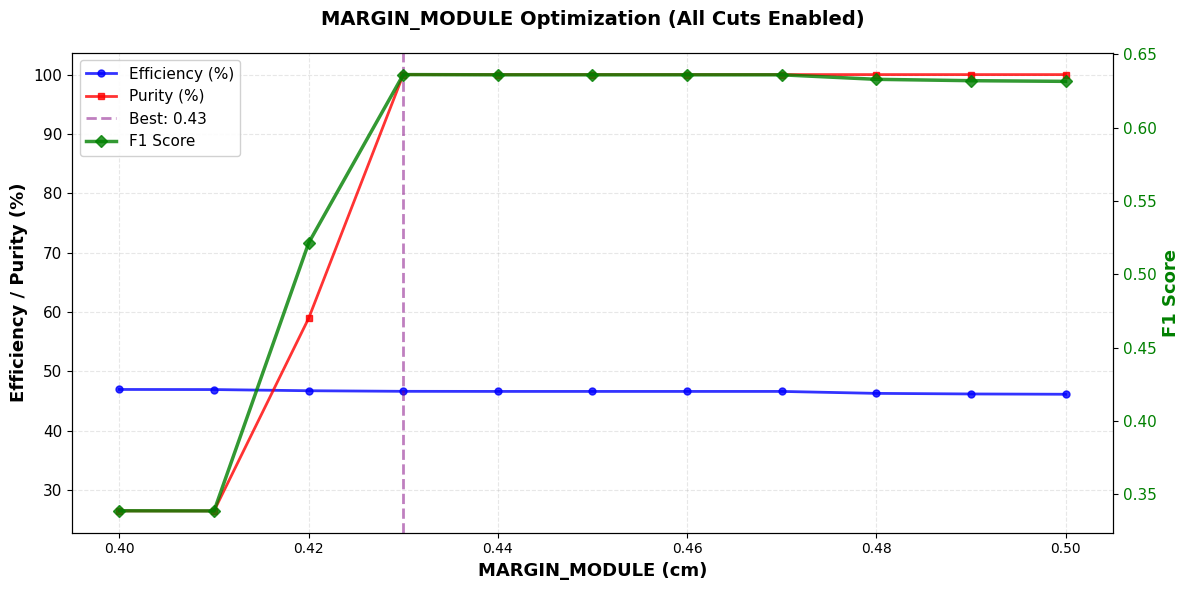


CURRENT PARAMETER VALUES (initial_params)
  MARGIN_MODULE                 : 0.43000000000000005 ← UPDATED
  MARGIN_DETECTOR               : 0.0
  ANGLE_CUT_MAX                 : 7.74
  DEDX_CUT_MIN                  : -99999
  DEDX_CUT_MAX                  : 2.62
  ETHETA2_CUT_MAX               : 5.78
  KE_CUT_MIN                    : 137.0
  PCA_TRANSVERSE_MAJOR_MIN      : 0.0
  PCA_TRANSVERSE_MINOR_MIN      : 0.005
  PROXIMITY_DISTANCE_THRESHOLD  : 0.38


In [54]:
# Optimize MARGIN_MODULE with all other cuts enabled
param_name = 'MARGIN_MODULE'

# Custom range and step size
lower_bound = 0.4
upper_bound = 0.5
step_size = 0.01

# Enable ALL cuts except the one being optimized
test_enable_flags = {
    'ENABLE_TOPOLOGY_CUT': True,
    'ENABLE_FIDUCIAL_CUT': True,
    'ENABLE_ANGLE_CUT': True,
    'ENABLE_DEDX_CUT': True,
    'ENABLE_ETHETA2_CUT': True,
    'ENABLE_KE_CUT': True,
    'ENABLE_PCA_CUT': True,
    'ENABLE_PROXIMITY_CUT': True,
}

# Use initial_params as base (initial guess for all other parameters)
test_params = initial_params.copy()

print("=" * 80)
print(f"Optimizing: {param_name} (with all other cuts enabled)")
print("=" * 80)
print(f"Range: [{lower_bound:.2f}, {upper_bound:.2f}], Step: {step_size:.2f}")
print(f"Initial value: {initial_params[param_name]:.2f}")
print("\nEnabled Cuts:")
for key, value in test_enable_flags.items():
    print(f"  {key}: {'✓' if value else '✗'}")
print("\nFixed Parameters (from initial_params):")
for key, value in initial_params.items():
    if key != param_name:
        print(f"  {key}: {value}")
print("=" * 80 + "\n")

import time
start_time = time.time()

# Generate test values
values = np.arange(lower_bound, upper_bound + step_size/2, step_size)
results = []

# Optimize with progress bar
for value in tqdm(values, desc=f"Scanning {param_name}"):
    test_params[param_name] = value
    
    efficiency, purity, f1, nuone_counts, fs_counts = calculate_efficiency_purity_f1(
        nuone_data, full_spill_data, test_params, test_enable_flags
    )
    
    background_count = fs_counts[1] - fs_counts[0]  # selected - true_1e_selected
    
    results.append({
        'value': value,
        'efficiency': efficiency,
        'eff_passed': nuone_counts[0],
        'eff_total': nuone_counts[1],
        'purity': purity,
        'background': background_count,
        'f1': f1
    })

elapsed = time.time() - start_time

# Output results in a table
print("\n" + "=" * 100)
print(f"OPTIMIZATION RESULTS: {param_name}")
print("=" * 100)
print(f"{'Value':>8s} | {'Efficiency':>20s} | {'Purity':>10s} | {'Background':>11s} | {'F1 Score':>10s}")
print("-" * 100)
for r in results:
    print(f"{r['value']:8.2f} | {r['efficiency']*100:6.2f}% ({r['eff_passed']:>4d}/{r['eff_total']:>4d}) | "
          f"{r['purity']*100:8.2f}% | {r['background']:>11d} | {r['f1']:10.4f}")

# Find best value
best_result = max(results, key=lambda x: x['f1'])
print("=" * 100)
print(f"⏱ Time: {elapsed:.1f}s")
print(f"\n✓ Best value: {best_result['value']:.2f}")
print(f"  Efficiency: {best_result['efficiency']*100:.2f}% ({best_result['eff_passed']}/{best_result['eff_total']})")
print(f"  Purity: {best_result['purity']*100:.2f}%")
print(f"  Background: {best_result['background']}")
print(f"  F1 Score: {best_result['f1']:.4f}")
print("=" * 100)

# Visualize results
fig, ax1 = plt.subplots(figsize=(12, 6))

param_values = [r['value'] for r in results]
efficiencies = [r['efficiency'] * 100 for r in results]
purities = [r['purity'] * 100 for r in results]
f1_scores = [r['f1'] for r in results]
backgrounds = [r['background'] for r in results]

# Plot Efficiency and Purity on left y-axis
ax1.plot(param_values, efficiencies, 'b-', linewidth=2, marker='o', markersize=5, 
         label='Efficiency (%)', alpha=0.8)
ax1.plot(param_values, purities, 'r-', linewidth=2, marker='s', markersize=5, 
         label='Purity (%)', alpha=0.8)
ax1.set_xlabel(f'{param_name} (cm)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Efficiency / Purity (%)', fontsize=13, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot F1 Score on right y-axis
ax2 = ax1.twinx()
ax2.plot(param_values, f1_scores, 'g-', linewidth=2.5, marker='D', markersize=6, 
         label='F1 Score', alpha=0.8)
ax2.set_ylabel('F1 Score', fontsize=13, fontweight='bold', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=11)

# Mark best value
ax1.axvline(best_result['value'], color='purple', linestyle='--', alpha=0.5, 
            linewidth=2, label=f"Best: {best_result['value']:.2f}")

plt.title(f'{param_name} Optimization (All Cuts Enabled)', fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

# Update initial_params with the optimized value
initial_params[param_name] = best_result['value']

# Print current parameters
print("\n" + "=" * 80)
print("CURRENT PARAMETER VALUES (initial_params)")
print("=" * 80)
for key, value in initial_params.items():
    marker = " ← UPDATED" if key == param_name else ""
    print(f"  {key:30s}: {value}{marker}")
print("=" * 80)

# Fiducial Cut - detector

Optimizing: MARGIN_DETECTOR (with all other cuts enabled)
Range: [0.00, 3.00], Step: 0.50
Initial value: 0.00

Enabled Cuts:
  ENABLE_TOPOLOGY_CUT: ✓
  ENABLE_FIDUCIAL_CUT: ✓
  ENABLE_ANGLE_CUT: ✓
  ENABLE_DEDX_CUT: ✓
  ENABLE_ETHETA2_CUT: ✓
  ENABLE_KE_CUT: ✓
  ENABLE_PCA_CUT: ✓
  ENABLE_PROXIMITY_CUT: ✓

Fixed Parameters (from initial_params):
  MARGIN_MODULE: 0.43000000000000005
  ANGLE_CUT_MAX: 7.74
  DEDX_CUT_MIN: -99999
  DEDX_CUT_MAX: 2.62
  ETHETA2_CUT_MAX: 5.78
  KE_CUT_MIN: 137.0
  PCA_TRANSVERSE_MAJOR_MIN: 0.0
  PCA_TRANSVERSE_MINOR_MIN: 0.005
  PROXIMITY_DISTANCE_THRESHOLD: 0.38



Scanning MARGIN_DETECTOR:   0%|          | 0/7 [00:00<?, ?it/s]

2830
11
11
2830
2830
11
11
2813
2813
11
11
2803
2803
11
11
2788
2788
10
10
2771
2771
10
10
2754
2754
10

OPTIMIZATION RESULTS: MARGIN_DETECTOR
   Value |           Efficiency |     Purity |  Background |   F1 Score
----------------------------------------------------------------------------------------------------
    0.00 |  46.65% (2830/6067) |   100.00% |           0 |     0.6362
    0.50 |  46.65% (2830/6067) |   100.00% |           0 |     0.6362
    1.00 |  46.37% (2813/6067) |   100.00% |           0 |     0.6336
    1.50 |  46.20% (2803/6067) |   100.00% |           0 |     0.6320
    2.00 |  45.95% (2788/6067) |   100.00% |           0 |     0.6297
    2.50 |  45.67% (2771/6067) |   100.00% |           0 |     0.6271
    3.00 |  45.39% (2754/6067) |   100.00% |           0 |     0.6244
⏱ Time: 8.2s

✓ Best value: 0.00
  Efficiency: 46.65% (2830/6067)
  Purity: 100.00%
  Background: 0
  F1 Score: 0.6362
10

OPTIMIZATION RESULTS: MARGIN_DETECTOR
   Value |           Efficiency |

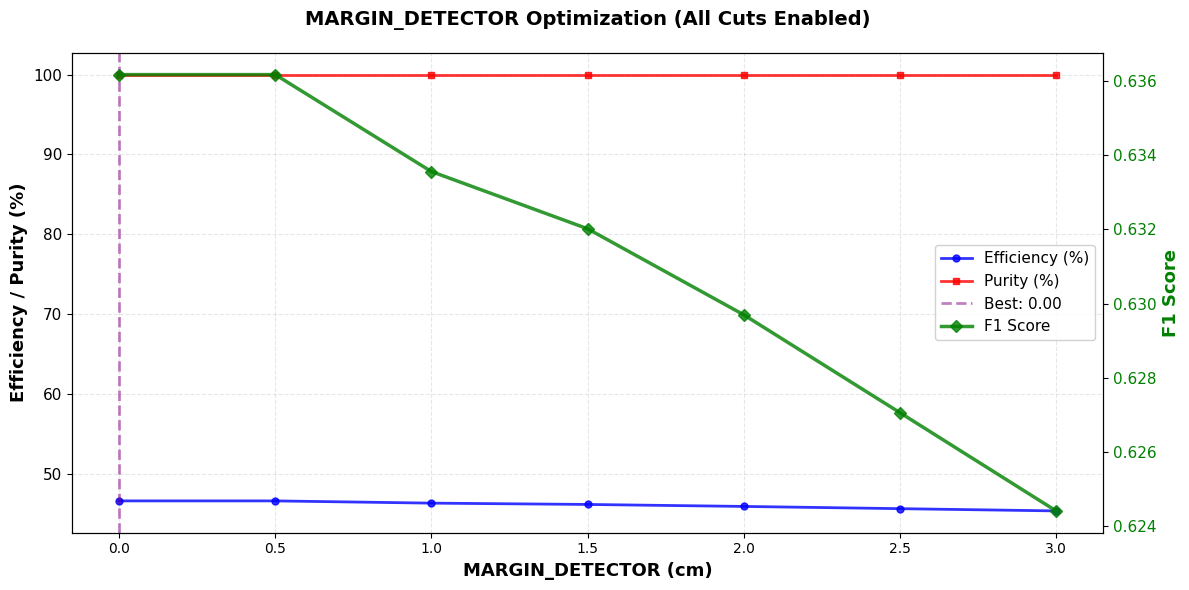


CURRENT PARAMETER VALUES (initial_params)
  MARGIN_MODULE                 : 0.43000000000000005
  MARGIN_DETECTOR               : 0.0 ← UPDATED
  ANGLE_CUT_MAX                 : 7.74
  DEDX_CUT_MIN                  : -99999
  DEDX_CUT_MAX                  : 2.62
  ETHETA2_CUT_MAX               : 5.78
  KE_CUT_MIN                    : 137.0
  PCA_TRANSVERSE_MAJOR_MIN      : 0.0
  PCA_TRANSVERSE_MINOR_MIN      : 0.005
  PROXIMITY_DISTANCE_THRESHOLD  : 0.38


In [55]:
# Optimize MARGIN_DETECTOR with all other cuts enabled
param_name = 'MARGIN_DETECTOR'

# Custom range and step size
lower_bound = 0.0
upper_bound = 3.0
step_size = 0.5

# Enable ALL cuts
test_enable_flags = {
    'ENABLE_TOPOLOGY_CUT': True,
    'ENABLE_FIDUCIAL_CUT': True,
    'ENABLE_ANGLE_CUT': True,
    'ENABLE_DEDX_CUT': True,
    'ENABLE_ETHETA2_CUT': True,
    'ENABLE_KE_CUT': True,
    'ENABLE_PCA_CUT': True,
    'ENABLE_PROXIMITY_CUT': True,
}

# Use initial_params as base (initial guess for all other parameters)
test_params = initial_params.copy()

print("=" * 80)
print(f"Optimizing: {param_name} (with all other cuts enabled)")
print("=" * 80)
print(f"Range: [{lower_bound:.2f}, {upper_bound:.2f}], Step: {step_size:.2f}")
print(f"Initial value: {initial_params[param_name]:.2f}")
print("\nEnabled Cuts:")
for key, value in test_enable_flags.items():
    print(f"  {key}: {'✓' if value else '✗'}")
print("\nFixed Parameters (from initial_params):")
for key, value in initial_params.items():
    if key != param_name:
        print(f"  {key}: {value}")
print("=" * 80 + "\n")

import time
start_time = time.time()

# Generate test values
values = np.arange(lower_bound, upper_bound + step_size/2, step_size)
results = []

# Optimize with progress bar
for value in tqdm(values, desc=f"Scanning {param_name}"):
    test_params[param_name] = value
    
    efficiency, purity, f1, nuone_counts, fs_counts = calculate_efficiency_purity_f1(
        nuone_data, full_spill_data, test_params, test_enable_flags
    )
    
    background_count = fs_counts[1] - fs_counts[0]  # selected - true_1e_selected
    
    results.append({
        'value': value,
        'efficiency': efficiency,
        'eff_passed': nuone_counts[0],
        'eff_total': nuone_counts[1],
        'purity': purity,
        'background': background_count,
        'f1': f1
    })

elapsed = time.time() - start_time

# Output results in a table
print("\n" + "=" * 100)
print(f"OPTIMIZATION RESULTS: {param_name}")
print("=" * 100)
print(f"{'Value':>8s} | {'Efficiency':>20s} | {'Purity':>10s} | {'Background':>11s} | {'F1 Score':>10s}")
print("-" * 100)
for r in results:
    print(f"{r['value']:8.2f} | {r['efficiency']*100:6.2f}% ({r['eff_passed']:>4d}/{r['eff_total']:>4d}) | "
          f"{r['purity']*100:8.2f}% | {r['background']:>11d} | {r['f1']:10.4f}")

# Find best value
best_result = max(results, key=lambda x: x['f1'])
print("=" * 100)
print(f"⏱ Time: {elapsed:.1f}s")
print(f"\n✓ Best value: {best_result['value']:.2f}")
print(f"  Efficiency: {best_result['efficiency']*100:.2f}% ({best_result['eff_passed']}/{best_result['eff_total']})")
print(f"  Purity: {best_result['purity']*100:.2f}%")
print(f"  Background: {best_result['background']}")
print(f"  F1 Score: {best_result['f1']:.4f}")
print("=" * 100)

# Visualize results
fig, ax1 = plt.subplots(figsize=(12, 6))

param_values = [r['value'] for r in results]
efficiencies = [r['efficiency'] * 100 for r in results]
purities = [r['purity'] * 100 for r in results]
f1_scores = [r['f1'] for r in results]
backgrounds = [r['background'] for r in results]

# Plot Efficiency and Purity on left y-axis
ax1.plot(param_values, efficiencies, 'b-', linewidth=2, marker='o', markersize=5, 
         label='Efficiency (%)', alpha=0.8)
ax1.plot(param_values, purities, 'r-', linewidth=2, marker='s', markersize=5, 
         label='Purity (%)', alpha=0.8)
ax1.set_xlabel(f'{param_name} (cm)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Efficiency / Purity (%)', fontsize=13, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot F1 Score on right y-axis
ax2 = ax1.twinx()
ax2.plot(param_values, f1_scores, 'g-', linewidth=2.5, marker='D', markersize=6, 
         label='F1 Score', alpha=0.8)
ax2.set_ylabel('F1 Score', fontsize=13, fontweight='bold', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=11)

# Mark best value
ax1.axvline(best_result['value'], color='purple', linestyle='--', alpha=0.5, 
            linewidth=2, label=f"Best: {best_result['value']:.2f}")

plt.title(f'{param_name} Optimization (All Cuts Enabled)', fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

# Update initial_params with the optimized value
initial_params[param_name] = best_result['value']

# Print current parameters
print("\n" + "=" * 80)
print("CURRENT PARAMETER VALUES (initial_params)")
print("=" * 80)
for key, value in initial_params.items():
    marker = " ← UPDATED" if key == param_name else ""
    print(f"  {key:30s}: {value}{marker}")
print("=" * 80)

# Angle Cut

Optimizing: ANGLE_CUT_MAX (with all other cuts enabled)
Range: [7.50, 10.00], Step: 0.04
Initial value: 7.74

Enabled Cuts:
  ENABLE_TOPOLOGY_CUT: ✓
  ENABLE_FIDUCIAL_CUT: ✓
  ENABLE_ANGLE_CUT: ✓
  ENABLE_DEDX_CUT: ✓
  ENABLE_ETHETA2_CUT: ✓
  ENABLE_KE_CUT: ✓
  ENABLE_PCA_CUT: ✓
  ENABLE_PROXIMITY_CUT: ✓

Fixed Parameters (from initial_params):
  MARGIN_MODULE: 0.43000000000000005
  MARGIN_DETECTOR: 0.0
  DEDX_CUT_MIN: -99999
  DEDX_CUT_MAX: 2.62
  ETHETA2_CUT_MAX: 5.78
  KE_CUT_MIN: 137.0
  PCA_TRANSVERSE_MAJOR_MIN: 0.0
  PCA_TRANSVERSE_MINOR_MIN: 0.005
  PROXIMITY_DISTANCE_THRESHOLD: 0.38



Scanning ANGLE_CUT_MAX:   0%|          | 0/63 [00:00<?, ?it/s]

2827
11
11
2827
2827
11
11
2828
2828
11
11
2828
2828
11
11
2828
2828
11
11
2828
2828
11
11
2830
2830
11
11
2831
2831
11
11
2831
2831
11
11
2831
2831
11
11
2831
2831
11
11
2831
2831
11
11
2831
2831
11
11
2831
2831
11
11
2831
2831
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
12

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

12

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None


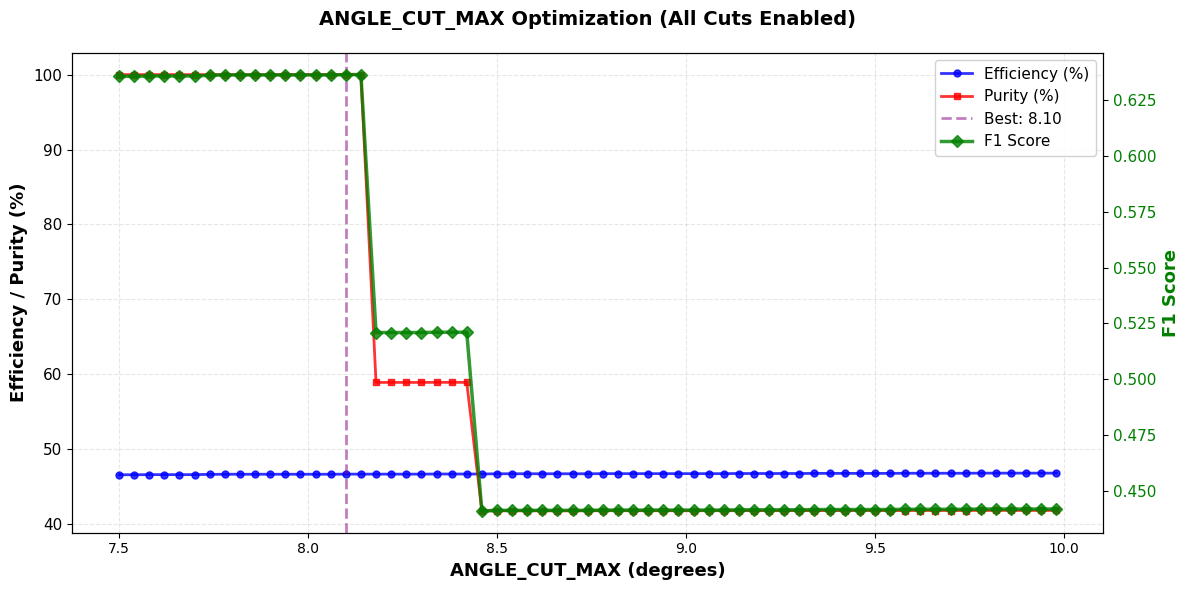


CURRENT PARAMETER VALUES (initial_params)
  MARGIN_MODULE                 : 0.43000000000000005
  MARGIN_DETECTOR               : 0.0
  ANGLE_CUT_MAX                 : 8.100000000000001 ← UPDATED
  DEDX_CUT_MIN                  : -99999
  DEDX_CUT_MAX                  : 2.62
  ETHETA2_CUT_MAX               : 5.78
  KE_CUT_MIN                    : 137.0
  PCA_TRANSVERSE_MAJOR_MIN      : 0.0
  PCA_TRANSVERSE_MINOR_MIN      : 0.005
  PROXIMITY_DISTANCE_THRESHOLD  : 0.38


In [56]:
# Optimize ANGLE_CUT_MAX with all other cuts enabled
param_name = 'ANGLE_CUT_MAX'

# Custom range and step size
lower_bound = 7.5
upper_bound = 10.0
step_size = 0.04

# Enable ALL cuts
test_enable_flags = {
    'ENABLE_TOPOLOGY_CUT': True,
    'ENABLE_FIDUCIAL_CUT': True,
    'ENABLE_ANGLE_CUT': True,
    'ENABLE_DEDX_CUT': True,
    'ENABLE_ETHETA2_CUT': True,
    'ENABLE_KE_CUT': True,
    'ENABLE_PCA_CUT': True,
    'ENABLE_PROXIMITY_CUT': True,
}

# Use initial_params as base (initial guess for all other parameters)
test_params = initial_params.copy()

print("=" * 80)
print(f"Optimizing: {param_name} (with all other cuts enabled)")
print("=" * 80)
print(f"Range: [{lower_bound:.2f}, {upper_bound:.2f}], Step: {step_size:.2f}")
print(f"Initial value: {initial_params[param_name]:.2f}")
print("\nEnabled Cuts:")
for key, value in test_enable_flags.items():
    print(f"  {key}: {'✓' if value else '✗'}")
print("\nFixed Parameters (from initial_params):")
for key, value in initial_params.items():
    if key != param_name:
        print(f"  {key}: {value}")
print("=" * 80 + "\n")

import time
start_time = time.time()

# Generate test values
values = np.arange(lower_bound, upper_bound + step_size/2, step_size)
results = []

# Optimize with progress bar
for value in tqdm(values, desc=f"Scanning {param_name}"):
    test_params[param_name] = value
    
    efficiency, purity, f1, nuone_counts, fs_counts = calculate_efficiency_purity_f1(
        nuone_data, full_spill_data, test_params, test_enable_flags
    )
    
    background_count = fs_counts[1] - fs_counts[0]  # selected - true_1e_selected
    
    results.append({
        'value': value,
        'efficiency': efficiency,
        'eff_passed': nuone_counts[0],
        'eff_total': nuone_counts[1],
        'purity': purity,
        'background': background_count,
        'f1': f1
    })

elapsed = time.time() - start_time

# Output results in a table
print("\n" + "=" * 100)
print(f"OPTIMIZATION RESULTS: {param_name}")
print("=" * 100)
print(f"{'Value':>8s} | {'Efficiency':>20s} | {'Purity':>10s} | {'Background':>11s} | {'F1 Score':>10s}")
print("-" * 100)
for r in results:
    print(f"{r['value']:8.2f} | {r['efficiency']*100:6.2f}% ({r['eff_passed']:>4d}/{r['eff_total']:>4d}) | "
          f"{r['purity']*100:8.2f}% | {r['background']:>11d} | {r['f1']:10.4f}")

# Find best value
best_result = max(results, key=lambda x: x['f1'])
print("=" * 100)
print(f"⏱ Time: {elapsed:.1f}s")
print(f"\n✓ Best value: {best_result['value']:.2f}")
print(f"  Efficiency: {best_result['efficiency']*100:.2f}% ({best_result['eff_passed']}/{best_result['eff_total']})")
print(f"  Purity: {best_result['purity']*100:.2f}%")
print(f"  Background: {best_result['background']}")
print(f"  F1 Score: {best_result['f1']:.4f}")
print("=" * 100)

# Visualize results
fig, ax1 = plt.subplots(figsize=(12, 6))

param_values = [r['value'] for r in results]
efficiencies = [r['efficiency'] * 100 for r in results]
purities = [r['purity'] * 100 for r in results]
f1_scores = [r['f1'] for r in results]
backgrounds = [r['background'] for r in results]

# Plot Efficiency and Purity on left y-axis
ax1.plot(param_values, efficiencies, 'b-', linewidth=2, marker='o', markersize=5, 
         label='Efficiency (%)', alpha=0.8)
ax1.plot(param_values, purities, 'r-', linewidth=2, marker='s', markersize=5, 
         label='Purity (%)', alpha=0.8)
ax1.set_xlabel(f'{param_name} (degrees)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Efficiency / Purity (%)', fontsize=13, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot F1 Score on right y-axis
ax2 = ax1.twinx()
ax2.plot(param_values, f1_scores, 'g-', linewidth=2.5, marker='D', markersize=6, 
         label='F1 Score', alpha=0.8)
ax2.set_ylabel('F1 Score', fontsize=13, fontweight='bold', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=11)

# Mark best value
ax1.axvline(best_result['value'], color='purple', linestyle='--', alpha=0.5, 
            linewidth=2, label=f"Best: {best_result['value']:.2f}")

plt.title(f'{param_name} Optimization (All Cuts Enabled)', fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

# Update initial_params with the optimized value
initial_params[param_name] = best_result['value']

# Print current parameters
print("\n" + "=" * 80)
print("CURRENT PARAMETER VALUES (initial_params)")
print("=" * 80)
for key, value in initial_params.items():
    marker = " ← UPDATED" if key == param_name else ""
    print(f"  {key:30s}: {value}{marker}")
print("=" * 80)

# dE/dx Cut

Optimizing: DEDX_CUT_MAX (with all other cuts enabled)
Range: [2.40, 2.80], Step: 0.02
Initial value: 2.62

Enabled Cuts:
  ENABLE_TOPOLOGY_CUT: ✓
  ENABLE_FIDUCIAL_CUT: ✓
  ENABLE_ANGLE_CUT: ✓
  ENABLE_DEDX_CUT: ✓
  ENABLE_ETHETA2_CUT: ✓
  ENABLE_KE_CUT: ✓
  ENABLE_PCA_CUT: ✓
  ENABLE_PROXIMITY_CUT: ✓

Fixed Parameters (from initial_params):
  MARGIN_MODULE: 0.43000000000000005
  MARGIN_DETECTOR: 0.0
  ANGLE_CUT_MAX: 8.100000000000001
  DEDX_CUT_MIN: -99999
  ETHETA2_CUT_MAX: 5.78
  KE_CUT_MIN: 137.0
  PCA_TRANSVERSE_MAJOR_MIN: 0.0
  PCA_TRANSVERSE_MINOR_MIN: 0.005
  PROXIMITY_DISTANCE_THRESHOLD: 0.38



Scanning DEDX_CUT_MAX:   0%|          | 0/21 [00:00<?, ?it/s]

2658
11
11
2681
2681
11
11
2702
2702
11
11
2722
2722
11
11
2734
2734
11
11
2755
2755
11
11
2769
2769
11
11
2787
2787
11
11
2799
2799
11
11
2812
2812
11
11
2821
2821
11
11
2832
2832
11
11
2847
2847
12

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

12

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfrome064 4.18.0-372.32.1.el8_6.x86_64 #1 SM

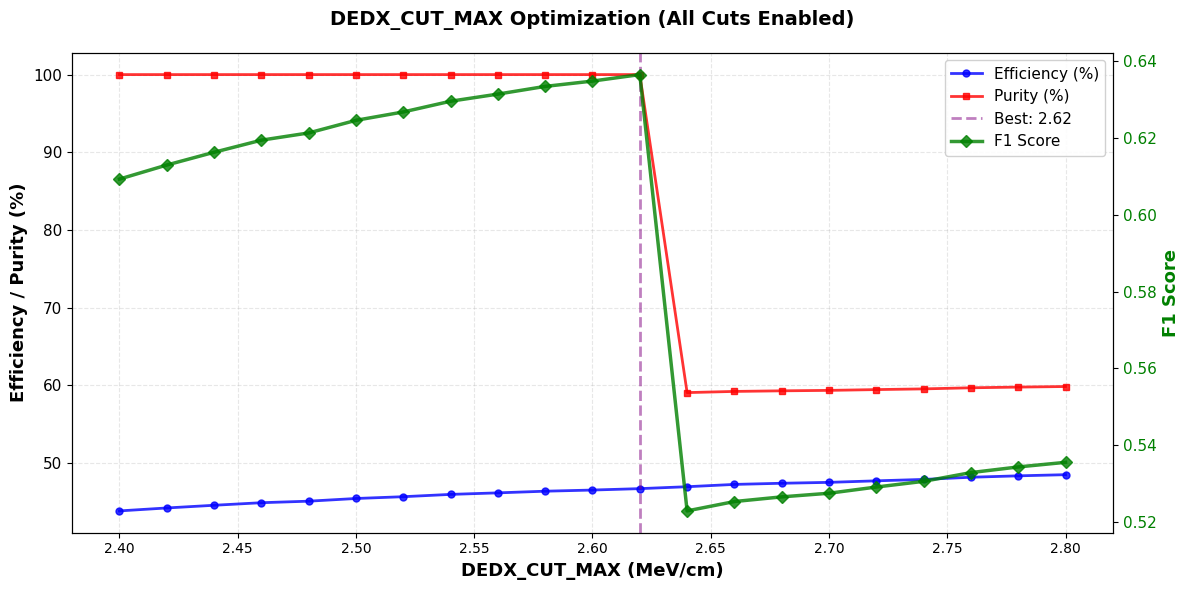


CURRENT PARAMETER VALUES (initial_params)
  MARGIN_MODULE                 : 0.43000000000000005
  MARGIN_DETECTOR               : 0.0
  ANGLE_CUT_MAX                 : 8.100000000000001
  DEDX_CUT_MIN                  : -99999
  DEDX_CUT_MAX                  : 2.62 ← UPDATED
  ETHETA2_CUT_MAX               : 5.78
  KE_CUT_MIN                    : 137.0
  PCA_TRANSVERSE_MAJOR_MIN      : 0.0
  PCA_TRANSVERSE_MINOR_MIN      : 0.005
  PROXIMITY_DISTANCE_THRESHOLD  : 0.38


In [57]:
# Optimize DEDX_CUT_MAX with all other cuts enabled
param_name = 'DEDX_CUT_MAX'

# Custom range and step size
lower_bound = 2.4
upper_bound = 2.8
step_size = 0.02

# Enable ALL cuts
test_enable_flags = {
    'ENABLE_TOPOLOGY_CUT': True,
    'ENABLE_FIDUCIAL_CUT': True,
    'ENABLE_ANGLE_CUT': True,
    'ENABLE_DEDX_CUT': True,
    'ENABLE_ETHETA2_CUT': True,
    'ENABLE_KE_CUT': True,
    'ENABLE_PCA_CUT': True,
    'ENABLE_PROXIMITY_CUT': True,
}

# Use initial_params as base (initial guess for all other parameters)
test_params = initial_params.copy()

print("=" * 80)
print(f"Optimizing: {param_name} (with all other cuts enabled)")
print("=" * 80)
print(f"Range: [{lower_bound:.2f}, {upper_bound:.2f}], Step: {step_size:.2f}")
print(f"Initial value: {initial_params[param_name]:.2f}")
print("\nEnabled Cuts:")
for key, value in test_enable_flags.items():
    print(f"  {key}: {'✓' if value else '✗'}")
print("\nFixed Parameters (from initial_params):")
for key, value in initial_params.items():
    if key != param_name:
        print(f"  {key}: {value}")
print("=" * 80 + "\n")

import time
start_time = time.time()

# Generate test values
values = np.arange(lower_bound, upper_bound + step_size/2, step_size)
results = []

# Optimize with progress bar
for value in tqdm(values, desc=f"Scanning {param_name}"):
    test_params[param_name] = value
    
    efficiency, purity, f1, nuone_counts, fs_counts = calculate_efficiency_purity_f1(
        nuone_data, full_spill_data, test_params, test_enable_flags
    )
    
    background_count = fs_counts[1] - fs_counts[0]  # selected - true_1e_selected
    
    results.append({
        'value': value,
        'efficiency': efficiency,
        'eff_passed': nuone_counts[0],
        'eff_total': nuone_counts[1],
        'purity': purity,
        'background': background_count,
        'f1': f1
    })

elapsed = time.time() - start_time

# Output results in a table
print("\n" + "=" * 100)
print(f"OPTIMIZATION RESULTS: {param_name}")
print("=" * 100)
print(f"{'Value':>8s} | {'Efficiency':>20s} | {'Purity':>10s} | {'Background':>11s} | {'F1 Score':>10s}")
print("-" * 100)
for r in results:
    print(f"{r['value']:8.2f} | {r['efficiency']*100:6.2f}% ({r['eff_passed']:>4d}/{r['eff_total']:>4d}) | "
          f"{r['purity']*100:8.2f}% | {r['background']:>11d} | {r['f1']:10.4f}")

# Find best value
best_result = max(results, key=lambda x: x['f1'])
print("=" * 100)
print(f"⏱ Time: {elapsed:.1f}s")
print(f"\n✓ Best value: {best_result['value']:.2f}")
print(f"  Efficiency: {best_result['efficiency']*100:.2f}% ({best_result['eff_passed']}/{best_result['eff_total']})")
print(f"  Purity: {best_result['purity']*100:.2f}%")
print(f"  Background: {best_result['background']}")
print(f"  F1 Score: {best_result['f1']:.4f}")
print("=" * 100)

# Visualize results
fig, ax1 = plt.subplots(figsize=(12, 6))

param_values = [r['value'] for r in results]
efficiencies = [r['efficiency'] * 100 for r in results]
purities = [r['purity'] * 100 for r in results]
f1_scores = [r['f1'] for r in results]
backgrounds = [r['background'] for r in results]

# Plot Efficiency and Purity on left y-axis
ax1.plot(param_values, efficiencies, 'b-', linewidth=2, marker='o', markersize=5, 
         label='Efficiency (%)', alpha=0.8)
ax1.plot(param_values, purities, 'r-', linewidth=2, marker='s', markersize=5, 
         label='Purity (%)', alpha=0.8)
ax1.set_xlabel(f'{param_name} (MeV/cm)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Efficiency / Purity (%)', fontsize=13, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot F1 Score on right y-axis
ax2 = ax1.twinx()
ax2.plot(param_values, f1_scores, 'g-', linewidth=2.5, marker='D', markersize=6, 
         label='F1 Score', alpha=0.8)
ax2.set_ylabel('F1 Score', fontsize=13, fontweight='bold', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=11)

# Mark best value
ax1.axvline(best_result['value'], color='purple', linestyle='--', alpha=0.5, 
            linewidth=2, label=f"Best: {best_result['value']:.2f}")

plt.title(f'{param_name} Optimization (All Cuts Enabled)', fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

# Update initial_params with the optimized value
initial_params[param_name] = best_result['value']

# Print current parameters
print("\n" + "=" * 80)
print("CURRENT PARAMETER VALUES (initial_params)")
print("=" * 80)
for key, value in initial_params.items():
    marker = " ← UPDATED" if key == param_name else ""
    print(f"  {key:30s}: {value}{marker}")
print("=" * 80)

# E*theta^2 Cut

Optimizing: ETHETA2_CUT_MAX (with all other cuts enabled)
Range: [5.00, 6.00], Step: 0.02
Initial value: 5.78

Enabled Cuts:
  ENABLE_TOPOLOGY_CUT: ✓
  ENABLE_FIDUCIAL_CUT: ✓
  ENABLE_ANGLE_CUT: ✓
  ENABLE_DEDX_CUT: ✓
  ENABLE_ETHETA2_CUT: ✓
  ENABLE_KE_CUT: ✓
  ENABLE_PCA_CUT: ✓
  ENABLE_PROXIMITY_CUT: ✓

Fixed Parameters (from initial_params):
  MARGIN_MODULE: 0.43000000000000005
  MARGIN_DETECTOR: 0.0
  ANGLE_CUT_MAX: 8.100000000000001
  DEDX_CUT_MIN: -99999
  DEDX_CUT_MAX: 2.62
  KE_CUT_MIN: 137.0
  PCA_TRANSVERSE_MAJOR_MIN: 0.0
  PCA_TRANSVERSE_MINOR_MIN: 0.005
  PROXIMITY_DISTANCE_THRESHOLD: 0.38



Scanning ETHETA2_CUT_MAX:   0%|          | 0/51 [00:00<?, ?it/s]

2782
10
10
2787
2787
10
10
2791
2791
10
10
2791
2791
10
10
2793
2793
10
10
2793
2793
10
10
2794
2794
10
10
2794
2794
10
10
2796
2796
10
10
2798
2798
10
10
2799
2799
10
10
2802
2802
10
10
2802
2802
10
10
2803
2803
10
10
2804
2804
10
10
2804
2804
10
10
2805
2805
10
10
2805
2805
10
10
2809
2809
10
10
2812
2812
10
10
2812
2812
10
10
2815
2815
10
10
2816
2816
10
10
2816
2816
10
10
2819
2819
10
10
2820
2820
10
10
2820
2820
10
10
2820
2820
10
10
2822
2822
10
10
2824
2824
10
10
2824
2824
10
10
2825
2825
10
10
2828
2828
10
10
2828
2828
10
10
2828
2828
10
10
2828
2828
11
11
2831
2831
11
11
2831
2831
11
11
2831
2831
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
12

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release versi

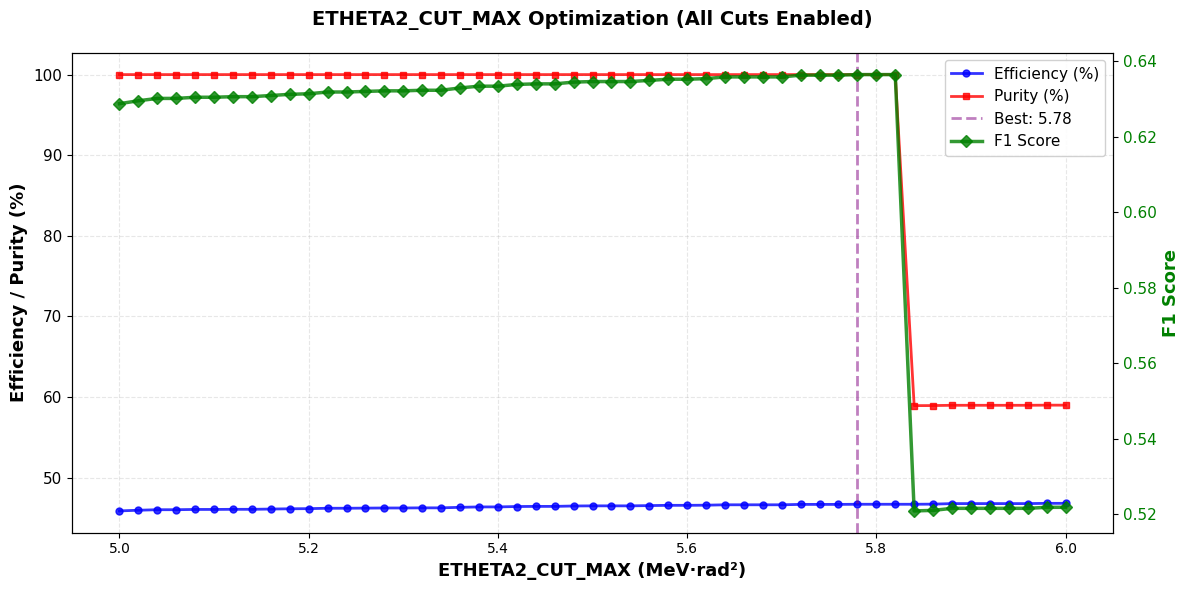


CURRENT PARAMETER VALUES (initial_params)
  MARGIN_MODULE                 : 0.43000000000000005
  MARGIN_DETECTOR               : 0.0
  ANGLE_CUT_MAX                 : 8.100000000000001
  DEDX_CUT_MIN                  : -99999
  DEDX_CUT_MAX                  : 2.62
  ETHETA2_CUT_MAX               : 5.779999999999983 ← UPDATED
  KE_CUT_MIN                    : 137.0
  PCA_TRANSVERSE_MAJOR_MIN      : 0.0
  PCA_TRANSVERSE_MINOR_MIN      : 0.005
  PROXIMITY_DISTANCE_THRESHOLD  : 0.38


In [58]:
# Optimize ETHETA2_CUT_MAX with all other cuts enabled
param_name = 'ETHETA2_CUT_MAX'

# Custom range and step size
lower_bound = 5.0
upper_bound = 6.0
step_size = 0.02

# Enable ALL cuts
test_enable_flags = {
    'ENABLE_TOPOLOGY_CUT': True,
    'ENABLE_FIDUCIAL_CUT': True,
    'ENABLE_ANGLE_CUT': True,
    'ENABLE_DEDX_CUT': True,
    'ENABLE_ETHETA2_CUT': True,
    'ENABLE_KE_CUT': True,
    'ENABLE_PCA_CUT': True,
    'ENABLE_PROXIMITY_CUT': True,
}

# Use initial_params as base (initial guess for all other parameters)
test_params = initial_params.copy()

print("=" * 80)
print(f"Optimizing: {param_name} (with all other cuts enabled)")
print("=" * 80)
print(f"Range: [{lower_bound:.2f}, {upper_bound:.2f}], Step: {step_size:.2f}")
print(f"Initial value: {initial_params[param_name]:.2f}")
print("\nEnabled Cuts:")
for key, value in test_enable_flags.items():
    print(f"  {key}: {'✓' if value else '✗'}")
print("\nFixed Parameters (from initial_params):")
for key, value in initial_params.items():
    if key != param_name:
        print(f"  {key}: {value}")
print("=" * 80 + "\n")

import time
start_time = time.time()

# Generate test values
values = np.arange(lower_bound, upper_bound + step_size/2, step_size)
results = []

# Optimize with progress bar
for value in tqdm(values, desc=f"Scanning {param_name}"):
    test_params[param_name] = value
    
    efficiency, purity, f1, nuone_counts, fs_counts = calculate_efficiency_purity_f1(
        nuone_data, full_spill_data, test_params, test_enable_flags
    )
    
    background_count = fs_counts[1] - fs_counts[0]  # selected - true_1e_selected
    
    results.append({
        'value': value,
        'efficiency': efficiency,
        'eff_passed': nuone_counts[0],
        'eff_total': nuone_counts[1],
        'purity': purity,
        'background': background_count,
        'f1': f1
    })

elapsed = time.time() - start_time

# Output results in a table
print("\n" + "=" * 100)
print(f"OPTIMIZATION RESULTS: {param_name}")
print("=" * 100)
print(f"{'Value':>8s} | {'Efficiency':>20s} | {'Purity':>10s} | {'Background':>11s} | {'F1 Score':>10s}")
print("-" * 100)
for r in results:
    print(f"{r['value']:8.2f} | {r['efficiency']*100:6.2f}% ({r['eff_passed']:>4d}/{r['eff_total']:>4d}) | "
          f"{r['purity']*100:8.2f}% | {r['background']:>11d} | {r['f1']:10.4f}")

# Find best value
best_result = max(results, key=lambda x: x['f1'])
print("=" * 100)
print(f"⏱ Time: {elapsed:.1f}s")
print(f"\n✓ Best value: {best_result['value']:.2f}")
print(f"  Efficiency: {best_result['efficiency']*100:.2f}% ({best_result['eff_passed']}/{best_result['eff_total']})")
print(f"  Purity: {best_result['purity']*100:.2f}%")
print(f"  Background: {best_result['background']}")
print(f"  F1 Score: {best_result['f1']:.4f}")
print("=" * 100)

# Visualize results
fig, ax1 = plt.subplots(figsize=(12, 6))

param_values = [r['value'] for r in results]
efficiencies = [r['efficiency'] * 100 for r in results]
purities = [r['purity'] * 100 for r in results]
f1_scores = [r['f1'] for r in results]
backgrounds = [r['background'] for r in results]

# Plot Efficiency and Purity on left y-axis
ax1.plot(param_values, efficiencies, 'b-', linewidth=2, marker='o', markersize=5, 
         label='Efficiency (%)', alpha=0.8)
ax1.plot(param_values, purities, 'r-', linewidth=2, marker='s', markersize=5, 
         label='Purity (%)', alpha=0.8)
ax1.set_xlabel(f'{param_name} (MeV·rad²)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Efficiency / Purity (%)', fontsize=13, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot F1 Score on right y-axis
ax2 = ax1.twinx()
ax2.plot(param_values, f1_scores, 'g-', linewidth=2.5, marker='D', markersize=6, 
         label='F1 Score', alpha=0.8)
ax2.set_ylabel('F1 Score', fontsize=13, fontweight='bold', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=11)

# Mark best value
ax1.axvline(best_result['value'], color='purple', linestyle='--', alpha=0.5, 
            linewidth=2, label=f"Best: {best_result['value']:.2f}")

plt.title(f'{param_name} Optimization (All Cuts Enabled)', fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

# Update initial_params with the optimized value
initial_params[param_name] = best_result['value']

# Print current parameters
print("\n" + "=" * 80)
print("CURRENT PARAMETER VALUES (initial_params)")
print("=" * 80)
for key, value in initial_params.items():
    marker = " ← UPDATED" if key == param_name else ""
    print(f"  {key:30s}: {value}{marker}")
print("=" * 80)

# Kinetic Energy Cut

Optimizing: KE_CUT_MIN (with all other cuts enabled)
Range: [130.00, 150.00], Step: 1.00
Initial value: 137.00

Enabled Cuts:
  ENABLE_TOPOLOGY_CUT: ✓
  ENABLE_FIDUCIAL_CUT: ✓
  ENABLE_ANGLE_CUT: ✓
  ENABLE_DEDX_CUT: ✓
  ENABLE_ETHETA2_CUT: ✓
  ENABLE_KE_CUT: ✓
  ENABLE_PCA_CUT: ✓
  ENABLE_PROXIMITY_CUT: ✓

Fixed Parameters (from initial_params):
  MARGIN_MODULE: 0.43000000000000005
  MARGIN_DETECTOR: 0.0
  ANGLE_CUT_MAX: 8.100000000000001
  DEDX_CUT_MIN: -99999
  DEDX_CUT_MAX: 2.62
  ETHETA2_CUT_MAX: 5.779999999999983
  PCA_TRANSVERSE_MAJOR_MIN: 0.0
  PCA_TRANSVERSE_MINOR_MIN: 0.005
  PROXIMITY_DISTANCE_THRESHOLD: 0.38



Scanning KE_CUT_MIN:   0%|          | 0/21 [00:00<?, ?it/s]

2852
12

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

12

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfrome064 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {verbosity: info, world_size: 0, seed: 1765512950}
io:
  reader: {file_keys: /sdf/data/neutrino/ndlar/spine/prod/microprod_n

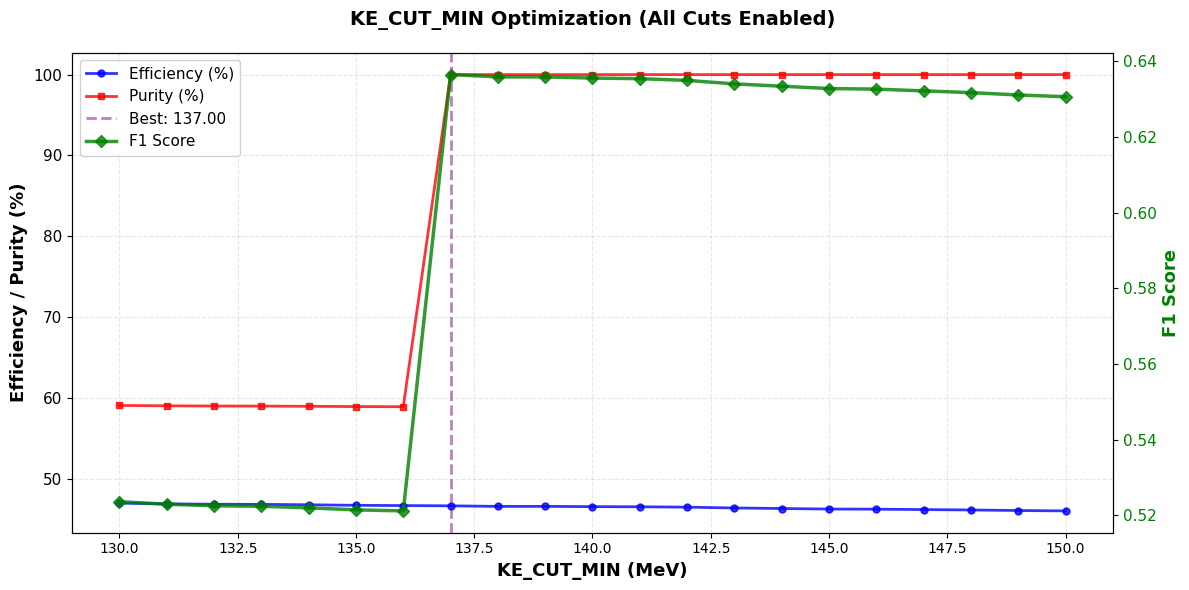


CURRENT PARAMETER VALUES (initial_params)
  MARGIN_MODULE                 : 0.43000000000000005
  MARGIN_DETECTOR               : 0.0
  ANGLE_CUT_MAX                 : 8.100000000000001
  DEDX_CUT_MIN                  : -99999
  DEDX_CUT_MAX                  : 2.62
  ETHETA2_CUT_MAX               : 5.779999999999983
  KE_CUT_MIN                    : 137.0 ← UPDATED
  PCA_TRANSVERSE_MAJOR_MIN      : 0.0
  PCA_TRANSVERSE_MINOR_MIN      : 0.005
  PROXIMITY_DISTANCE_THRESHOLD  : 0.38


In [59]:
# Optimize KE_CUT_MIN with all other cuts enabled
param_name = 'KE_CUT_MIN'

# Custom range and step size
lower_bound = 130
upper_bound = 150.0
step_size = 1.0

# Enable ALL cuts
test_enable_flags = {
    'ENABLE_TOPOLOGY_CUT': True,
    'ENABLE_FIDUCIAL_CUT': True,
    'ENABLE_ANGLE_CUT': True,
    'ENABLE_DEDX_CUT': True,
    'ENABLE_ETHETA2_CUT': True,
    'ENABLE_KE_CUT': True,
    'ENABLE_PCA_CUT': True,
    'ENABLE_PROXIMITY_CUT': True,
}

# Use initial_params as base (initial guess for all other parameters)
test_params = initial_params.copy()

print("=" * 80)
print(f"Optimizing: {param_name} (with all other cuts enabled)")
print("=" * 80)
print(f"Range: [{lower_bound:.2f}, {upper_bound:.2f}], Step: {step_size:.2f}")
print(f"Initial value: {initial_params[param_name]:.2f}")
print("\nEnabled Cuts:")
for key, value in test_enable_flags.items():
    print(f"  {key}: {'✓' if value else '✗'}")
print("\nFixed Parameters (from initial_params):")
for key, value in initial_params.items():
    if key != param_name:
        print(f"  {key}: {value}")
print("=" * 80 + "\n")

import time
start_time = time.time()

# Generate test values
values = np.arange(lower_bound, upper_bound + step_size/2, step_size)
results = []

# Optimize with progress bar
for value in tqdm(values, desc=f"Scanning {param_name}"):
    test_params[param_name] = value
    
    efficiency, purity, f1, nuone_counts, fs_counts = calculate_efficiency_purity_f1(
        nuone_data, full_spill_data, test_params, test_enable_flags
    )
    
    background_count = fs_counts[1] - fs_counts[0]  # selected - true_1e_selected
    
    results.append({
        'value': value,
        'efficiency': efficiency,
        'eff_passed': nuone_counts[0],
        'eff_total': nuone_counts[1],
        'purity': purity,
        'background': background_count,
        'f1': f1
    })

elapsed = time.time() - start_time

# Output results in a table
print("\n" + "=" * 100)
print(f"OPTIMIZATION RESULTS: {param_name}")
print("=" * 100)
print(f"{'Value':>8s} | {'Efficiency':>20s} | {'Purity':>10s} | {'Background':>11s} | {'F1 Score':>10s}")
print("-" * 100)
for r in results:
    print(f"{r['value']:8.2f} | {r['efficiency']*100:6.2f}% ({r['eff_passed']:>4d}/{r['eff_total']:>4d}) | "
          f"{r['purity']*100:8.2f}% | {r['background']:>11d} | {r['f1']:10.4f}")

# Find best value
best_result = max(results, key=lambda x: x['f1'])
print("=" * 100)
print(f"⏱ Time: {elapsed:.1f}s")
print(f"\n✓ Best value: {best_result['value']:.2f}")
print(f"  Efficiency: {best_result['efficiency']*100:.2f}% ({best_result['eff_passed']}/{best_result['eff_total']})")
print(f"  Purity: {best_result['purity']*100:.2f}%")
print(f"  Background: {best_result['background']}")
print(f"  F1 Score: {best_result['f1']:.4f}")
print("=" * 100)

# Visualize results
fig, ax1 = plt.subplots(figsize=(12, 6))

param_values = [r['value'] for r in results]
efficiencies = [r['efficiency'] * 100 for r in results]
purities = [r['purity'] * 100 for r in results]
f1_scores = [r['f1'] for r in results]
backgrounds = [r['background'] for r in results]

# Plot Efficiency and Purity on left y-axis
ax1.plot(param_values, efficiencies, 'b-', linewidth=2, marker='o', markersize=5, 
         label='Efficiency (%)', alpha=0.8)
ax1.plot(param_values, purities, 'r-', linewidth=2, marker='s', markersize=5, 
         label='Purity (%)', alpha=0.8)
ax1.set_xlabel(f'{param_name} (MeV)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Efficiency / Purity (%)', fontsize=13, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot F1 Score on right y-axis
ax2 = ax1.twinx()
ax2.plot(param_values, f1_scores, 'g-', linewidth=2.5, marker='D', markersize=6, 
         label='F1 Score', alpha=0.8)
ax2.set_ylabel('F1 Score', fontsize=13, fontweight='bold', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=11)

# Mark best value
ax1.axvline(best_result['value'], color='purple', linestyle='--', alpha=0.5, 
            linewidth=2, label=f"Best: {best_result['value']:.2f}")

plt.title(f'{param_name} Optimization (All Cuts Enabled)', fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

# Update initial_params with the optimized value
initial_params[param_name] = best_result['value']

# Print current parameters
print("\n" + "=" * 80)
print("CURRENT PARAMETER VALUES (initial_params)")
print("=" * 80)
for key, value in initial_params.items():
    marker = " ← UPDATED" if key == param_name else ""
    print(f"  {key:30s}: {value}{marker}")
print("=" * 80)

# PCA_TRANSVERSE_MAJOR_MIN

Optimizing: PCA_TRANSVERSE_MAJOR_MIN (with all other cuts enabled)
Range: [0.000, 0.050], Step: 0.010
Initial value: 0.000

Enabled Cuts:
  ENABLE_TOPOLOGY_CUT: ✓
  ENABLE_FIDUCIAL_CUT: ✓
  ENABLE_ANGLE_CUT: ✓
  ENABLE_DEDX_CUT: ✓
  ENABLE_ETHETA2_CUT: ✓
  ENABLE_KE_CUT: ✓
  ENABLE_PCA_CUT: ✓
  ENABLE_PROXIMITY_CUT: ✓

Fixed Parameters (from initial_params):
  MARGIN_MODULE: 0.43000000000000005
  MARGIN_DETECTOR: 0.0
  ANGLE_CUT_MAX: 8.100000000000001
  DEDX_CUT_MIN: -99999
  DEDX_CUT_MAX: 2.62
  ETHETA2_CUT_MAX: 5.779999999999983
  KE_CUT_MIN: 137.0
  PCA_TRANSVERSE_MINOR_MIN: 0.005
  PROXIMITY_DISTANCE_THRESHOLD: 0.38



Scanning PCA_TRANSVERSE_MAJOR_MIN:   0%|          | 0/6 [00:00<?, ?it/s]

2832
11
11
2832
2832
11
11
2832
2832
11
11
2830
2830
11
11
2817
2817
11
11
2798
2798
11

OPTIMIZATION RESULTS: PCA_TRANSVERSE_MAJOR_MIN
   Value |           Efficiency |     Purity |  Background |   F1 Score
----------------------------------------------------------------------------------------------------
   0.000 |  46.68% (2832/6067) |   100.00% |           0 |     0.6365
   0.010 |  46.68% (2832/6067) |   100.00% |           0 |     0.6365
   0.020 |  46.68% (2832/6067) |   100.00% |           0 |     0.6365
   0.030 |  46.65% (2830/6067) |   100.00% |           0 |     0.6362
   0.040 |  46.43% (2817/6067) |   100.00% |           0 |     0.6342
   0.050 |  46.12% (2798/6067) |   100.00% |           0 |     0.6312
⏱ Time: 7.1s

✓ Best value: 0.000
  Efficiency: 46.68% (2832/6067)
  Purity: 100.00%
  Background: 0
  F1 Score: 0.6365
11

OPTIMIZATION RESULTS: PCA_TRANSVERSE_MAJOR_MIN
   Value |           Efficiency |     Purity |  Background |   F1 Score
----------------------------

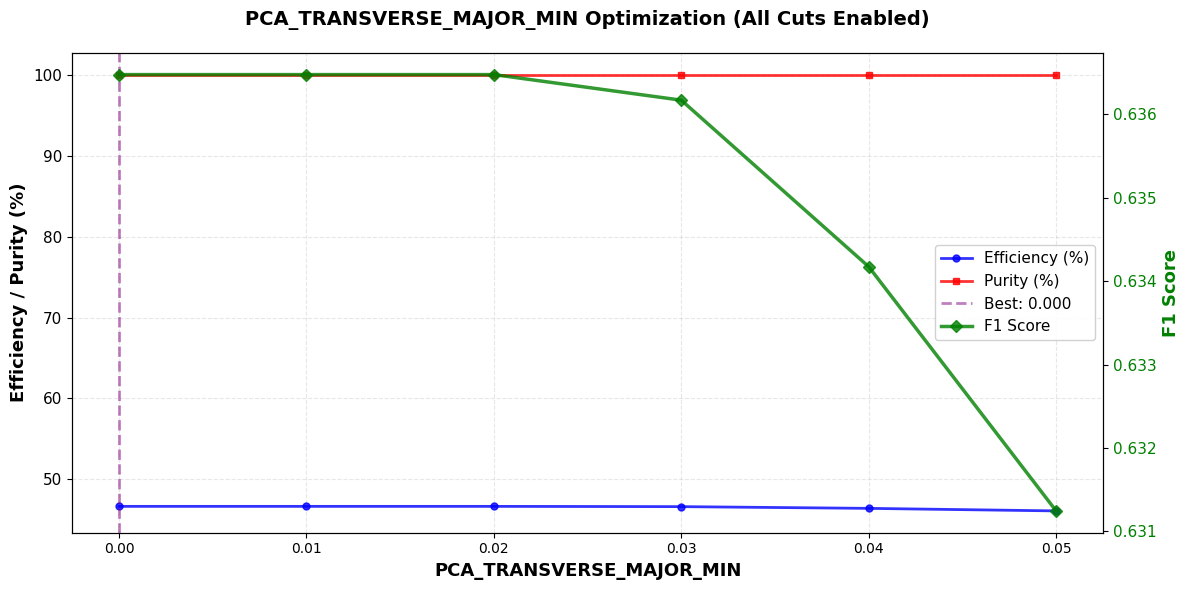


CURRENT PARAMETER VALUES (initial_params)
  MARGIN_MODULE                 : 0.43000000000000005
  MARGIN_DETECTOR               : 0.0
  ANGLE_CUT_MAX                 : 8.100000000000001
  DEDX_CUT_MIN                  : -99999
  DEDX_CUT_MAX                  : 2.62
  ETHETA2_CUT_MAX               : 5.779999999999983
  KE_CUT_MIN                    : 137.0
  PCA_TRANSVERSE_MAJOR_MIN      : 0.0 ← UPDATED
  PCA_TRANSVERSE_MINOR_MIN      : 0.005
  PROXIMITY_DISTANCE_THRESHOLD  : 0.38


In [60]:
# Optimize PCA_TRANSVERSE_MAJOR_MIN with all other cuts enabled
param_name = 'PCA_TRANSVERSE_MAJOR_MIN'

# Custom range and step size
lower_bound = 0.00
upper_bound = 0.05
step_size = 0.01

# Enable ALL cuts
test_enable_flags = {
    'ENABLE_TOPOLOGY_CUT': True,
    'ENABLE_FIDUCIAL_CUT': True,
    'ENABLE_ANGLE_CUT': True,
    'ENABLE_DEDX_CUT': True,
    'ENABLE_ETHETA2_CUT': True,
    'ENABLE_KE_CUT': True,
    'ENABLE_PCA_CUT': True,
    'ENABLE_PROXIMITY_CUT': True,
}

# Use initial_params as base (initial guess for all other parameters)
test_params = initial_params.copy()

print("=" * 80)
print(f"Optimizing: {param_name} (with all other cuts enabled)")
print("=" * 80)
print(f"Range: [{lower_bound:.3f}, {upper_bound:.3f}], Step: {step_size:.3f}")
print(f"Initial value: {initial_params[param_name]:.3f}")
print("\nEnabled Cuts:")
for key, value in test_enable_flags.items():
    print(f"  {key}: {'✓' if value else '✗'}")
print("\nFixed Parameters (from initial_params):")
for key, value in initial_params.items():
    if key != param_name:
        print(f"  {key}: {value}")
print("=" * 80 + "\n")

import time
start_time = time.time()

# Generate test values
values = np.arange(lower_bound, upper_bound + step_size/2, step_size)
results = []

# Optimize with progress bar
for value in tqdm(values, desc=f"Scanning {param_name}"):
    test_params[param_name] = value
    
    efficiency, purity, f1, nuone_counts, fs_counts = calculate_efficiency_purity_f1(
        nuone_data, full_spill_data, test_params, test_enable_flags
    )
    
    background_count = fs_counts[1] - fs_counts[0]  # selected - true_1e_selected
    
    results.append({
        'value': value,
        'efficiency': efficiency,
        'eff_passed': nuone_counts[0],
        'eff_total': nuone_counts[1],
        'purity': purity,
        'background': background_count,
        'f1': f1
    })

elapsed = time.time() - start_time

# Output results in a table
print("\n" + "=" * 100)
print(f"OPTIMIZATION RESULTS: {param_name}")
print("=" * 100)
print(f"{'Value':>8s} | {'Efficiency':>20s} | {'Purity':>10s} | {'Background':>11s} | {'F1 Score':>10s}")
print("-" * 100)
for r in results:
    print(f"{r['value']:8.3f} | {r['efficiency']*100:6.2f}% ({r['eff_passed']:>4d}/{r['eff_total']:>4d}) | "
          f"{r['purity']*100:8.2f}% | {r['background']:>11d} | {r['f1']:10.4f}")

# Find best value
best_result = max(results, key=lambda x: x['f1'])
print("=" * 100)
print(f"⏱ Time: {elapsed:.1f}s")
print(f"\n✓ Best value: {best_result['value']:.3f}")
print(f"  Efficiency: {best_result['efficiency']*100:.2f}% ({best_result['eff_passed']}/{best_result['eff_total']})")
print(f"  Purity: {best_result['purity']*100:.2f}%")
print(f"  Background: {best_result['background']}")
print(f"  F1 Score: {best_result['f1']:.4f}")
print("=" * 100)

# Visualize results
fig, ax1 = plt.subplots(figsize=(12, 6))

param_values = [r['value'] for r in results]
efficiencies = [r['efficiency'] * 100 for r in results]
purities = [r['purity'] * 100 for r in results]
f1_scores = [r['f1'] for r in results]
backgrounds = [r['background'] for r in results]

# Plot Efficiency and Purity on left y-axis
ax1.plot(param_values, efficiencies, 'b-', linewidth=2, marker='o', markersize=5, 
         label='Efficiency (%)', alpha=0.8)
ax1.plot(param_values, purities, 'r-', linewidth=2, marker='s', markersize=5, 
         label='Purity (%)', alpha=0.8)
ax1.set_xlabel(f'{param_name}', fontsize=13, fontweight='bold')
ax1.set_ylabel('Efficiency / Purity (%)', fontsize=13, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot F1 Score on right y-axis
ax2 = ax1.twinx()
ax2.plot(param_values, f1_scores, 'g-', linewidth=2.5, marker='D', markersize=6, 
         label='F1 Score', alpha=0.8)
ax2.set_ylabel('F1 Score', fontsize=13, fontweight='bold', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=11)

# Mark best value
ax1.axvline(best_result['value'], color='purple', linestyle='--', alpha=0.5, 
            linewidth=2, label=f"Best: {best_result['value']:.3f}")

plt.title(f'{param_name} Optimization (All Cuts Enabled)', fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

# Update initial_params with the optimized value
initial_params[param_name] = best_result['value']

# Print current parameters
print("\n" + "=" * 80)
print("CURRENT PARAMETER VALUES (initial_params)")
print("=" * 80)
for key, value in initial_params.items():
    marker = " ← UPDATED" if key == param_name else ""
    print(f"  {key:30s}: {value}{marker}")
print("=" * 80)

# PCA_TRANSVERSE_MINOR_MIN

Optimizing: PCA_TRANSVERSE_MINOR_MIN (with all other cuts enabled)
Range: [0.000, 0.020], Step: 0.005
Initial value: 0.005

Enabled Cuts:
  ENABLE_TOPOLOGY_CUT: ✓
  ENABLE_FIDUCIAL_CUT: ✓
  ENABLE_ANGLE_CUT: ✓
  ENABLE_DEDX_CUT: ✓
  ENABLE_ETHETA2_CUT: ✓
  ENABLE_KE_CUT: ✓
  ENABLE_PCA_CUT: ✓
  ENABLE_PROXIMITY_CUT: ✓

Fixed Parameters (from initial_params):
  MARGIN_MODULE: 0.43000000000000005
  MARGIN_DETECTOR: 0.0
  ANGLE_CUT_MAX: 8.100000000000001
  DEDX_CUT_MIN: -99999
  DEDX_CUT_MAX: 2.62
  ETHETA2_CUT_MAX: 5.779999999999983
  KE_CUT_MIN: 137.0
  PCA_TRANSVERSE_MAJOR_MIN: 0.0
  PROXIMITY_DISTANCE_THRESHOLD: 0.38



Scanning PCA_TRANSVERSE_MINOR_MIN:   0%|          | 0/5 [00:00<?, ?it/s]

2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2823
2823
11

OPTIMIZATION RESULTS: PCA_TRANSVERSE_MINOR_MIN
   Value |           Efficiency |     Purity |  Background |   F1 Score
----------------------------------------------------------------------------------------------------
   0.000 |  46.68% (2832/6067) |   100.00% |           0 |     0.6365
   0.005 |  46.68% (2832/6067) |   100.00% |           0 |     0.6365
   0.010 |  46.68% (2832/6067) |   100.00% |           0 |     0.6365
   0.015 |  46.68% (2832/6067) |   100.00% |           0 |     0.6365
   0.020 |  46.53% (2823/6067) |   100.00% |           0 |     0.6351
⏱ Time: 5.9s

✓ Best value: 0.000
  Efficiency: 46.68% (2832/6067)
  Purity: 100.00%
  Background: 0
  F1 Score: 0.6365
11

OPTIMIZATION RESULTS: PCA_TRANSVERSE_MINOR_MIN
   Value |           Efficiency |     Purity |  Background |   F1 Score
----------------------------------------------------------------------------------------------------
   0.000 |  4

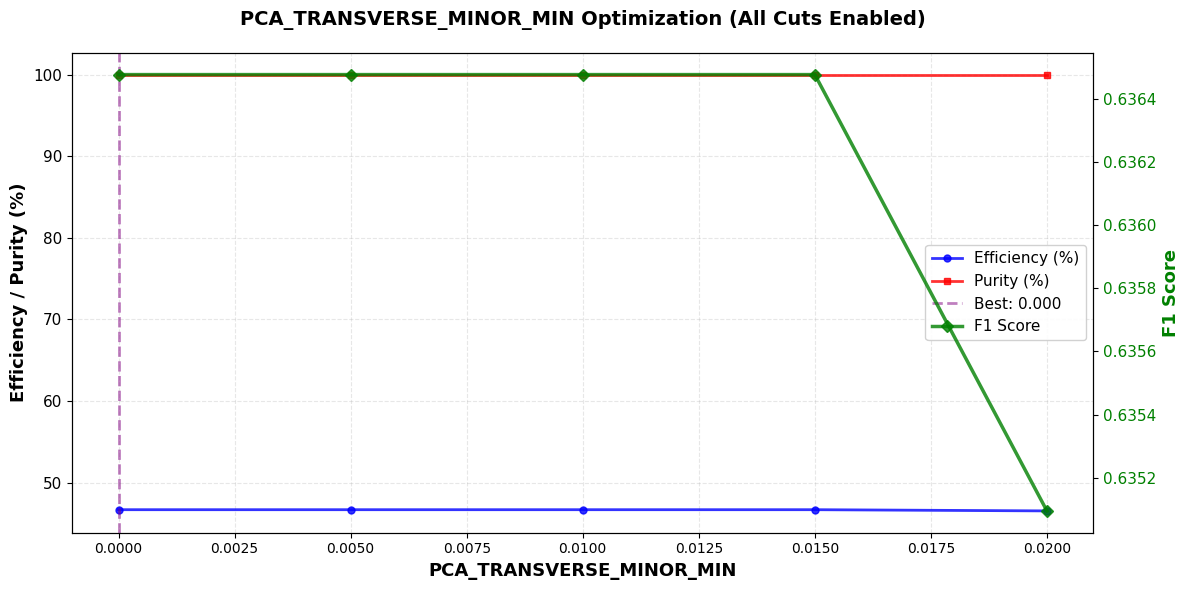


CURRENT PARAMETER VALUES (initial_params)
  MARGIN_MODULE                 : 0.43000000000000005
  MARGIN_DETECTOR               : 0.0
  ANGLE_CUT_MAX                 : 8.100000000000001
  DEDX_CUT_MIN                  : -99999
  DEDX_CUT_MAX                  : 2.62
  ETHETA2_CUT_MAX               : 5.779999999999983
  KE_CUT_MIN                    : 137.0
  PCA_TRANSVERSE_MAJOR_MIN      : 0.0
  PCA_TRANSVERSE_MINOR_MIN      : 0.0 ← UPDATED
  PROXIMITY_DISTANCE_THRESHOLD  : 0.38


In [61]:
# Optimize PCA_TRANSVERSE_MINOR_MIN with all other cuts enabled
param_name = 'PCA_TRANSVERSE_MINOR_MIN'

# Custom range and step size
lower_bound = 0.000
upper_bound = 0.02
step_size = 0.005

# Enable ALL cuts
test_enable_flags = {
    'ENABLE_TOPOLOGY_CUT': True,
    'ENABLE_FIDUCIAL_CUT': True,
    'ENABLE_ANGLE_CUT': True,
    'ENABLE_DEDX_CUT': True,
    'ENABLE_ETHETA2_CUT': True,
    'ENABLE_KE_CUT': True,
    'ENABLE_PCA_CUT': True,
    'ENABLE_PROXIMITY_CUT': True,
}

# Use initial_params as base (initial guess for all other parameters)
test_params = initial_params.copy()

print("=" * 80)
print(f"Optimizing: {param_name} (with all other cuts enabled)")
print("=" * 80)
print(f"Range: [{lower_bound:.3f}, {upper_bound:.3f}], Step: {step_size:.3f}")
print(f"Initial value: {initial_params[param_name]:.3f}")
print("\nEnabled Cuts:")
for key, value in test_enable_flags.items():
    print(f"  {key}: {'✓' if value else '✗'}")
print("\nFixed Parameters (from initial_params):")
for key, value in initial_params.items():
    if key != param_name:
        print(f"  {key}: {value}")
print("=" * 80 + "\n")

import time
start_time = time.time()

# Generate test values
values = np.arange(lower_bound, upper_bound + step_size/2, step_size)
results = []

# Optimize with progress bar
for value in tqdm(values, desc=f"Scanning {param_name}"):
    test_params[param_name] = value
    
    efficiency, purity, f1, nuone_counts, fs_counts = calculate_efficiency_purity_f1(
        nuone_data, full_spill_data, test_params, test_enable_flags
    )
    
    background_count = fs_counts[1] - fs_counts[0]  # selected - true_1e_selected
    
    results.append({
        'value': value,
        'efficiency': efficiency,
        'eff_passed': nuone_counts[0],
        'eff_total': nuone_counts[1],
        'purity': purity,
        'background': background_count,
        'f1': f1
    })

elapsed = time.time() - start_time

# Output results in a table
print("\n" + "=" * 100)
print(f"OPTIMIZATION RESULTS: {param_name}")
print("=" * 100)
print(f"{'Value':>8s} | {'Efficiency':>20s} | {'Purity':>10s} | {'Background':>11s} | {'F1 Score':>10s}")
print("-" * 100)
for r in results:
    print(f"{r['value']:8.3f} | {r['efficiency']*100:6.2f}% ({r['eff_passed']:>4d}/{r['eff_total']:>4d}) | "
          f"{r['purity']*100:8.2f}% | {r['background']:>11d} | {r['f1']:10.4f}")

# Find best value
best_result = max(results, key=lambda x: x['f1'])
print("=" * 100)
print(f"⏱ Time: {elapsed:.1f}s")
print(f"\n✓ Best value: {best_result['value']:.3f}")
print(f"  Efficiency: {best_result['efficiency']*100:.2f}% ({best_result['eff_passed']}/{best_result['eff_total']})")
print(f"  Purity: {best_result['purity']*100:.2f}%")
print(f"  Background: {best_result['background']}")
print(f"  F1 Score: {best_result['f1']:.4f}")
print("=" * 100)

# Visualize results
fig, ax1 = plt.subplots(figsize=(12, 6))

param_values = [r['value'] for r in results]
efficiencies = [r['efficiency'] * 100 for r in results]
purities = [r['purity'] * 100 for r in results]
f1_scores = [r['f1'] for r in results]
backgrounds = [r['background'] for r in results]

# Plot Efficiency and Purity on left y-axis
ax1.plot(param_values, efficiencies, 'b-', linewidth=2, marker='o', markersize=5, 
         label='Efficiency (%)', alpha=0.8)
ax1.plot(param_values, purities, 'r-', linewidth=2, marker='s', markersize=5, 
         label='Purity (%)', alpha=0.8)
ax1.set_xlabel(f'{param_name}', fontsize=13, fontweight='bold')
ax1.set_ylabel('Efficiency / Purity (%)', fontsize=13, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot F1 Score on right y-axis
ax2 = ax1.twinx()
ax2.plot(param_values, f1_scores, 'g-', linewidth=2.5, marker='D', markersize=6, 
         label='F1 Score', alpha=0.8)
ax2.set_ylabel('F1 Score', fontsize=13, fontweight='bold', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=11)

# Mark best value
ax1.axvline(best_result['value'], color='purple', linestyle='--', alpha=0.5, 
            linewidth=2, label=f"Best: {best_result['value']:.3f}")

plt.title(f'{param_name} Optimization (All Cuts Enabled)', fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

# Update initial_params with the optimized value
initial_params[param_name] = best_result['value']

# Print current parameters
print("\n" + "=" * 80)
print("CURRENT PARAMETER VALUES (initial_params)")
print("=" * 80)
for key, value in initial_params.items():
    marker = " ← UPDATED" if key == param_name else ""
    print(f"  {key:30s}: {value}{marker}")
print("=" * 80)

# Seperation Distance

Optimizing: PROXIMITY_DISTANCE_THRESHOLD (with all other cuts enabled)
Range: [0.3, 0.5], Step: 0.0
Initial value: 0.4

Enabled Cuts:
  ENABLE_TOPOLOGY_CUT: ✓
  ENABLE_FIDUCIAL_CUT: ✓
  ENABLE_ANGLE_CUT: ✓
  ENABLE_DEDX_CUT: ✓
  ENABLE_ETHETA2_CUT: ✓
  ENABLE_KE_CUT: ✓
  ENABLE_PCA_CUT: ✓
  ENABLE_PROXIMITY_CUT: ✓

Fixed Parameters (from initial_params):
  MARGIN_MODULE: 0.43000000000000005
  MARGIN_DETECTOR: 0.0
  ANGLE_CUT_MAX: 8.100000000000001
  DEDX_CUT_MIN: -99999
  DEDX_CUT_MAX: 2.62
  ETHETA2_CUT_MAX: 5.779999999999983
  KE_CUT_MIN: 137.0
  PCA_TRANSVERSE_MAJOR_MIN: 0.0
  PCA_TRANSVERSE_MINOR_MIN: 0.0



Scanning PROXIMITY_DISTANCE_THRESHOLD:   0%|          | 0/21 [00:00<?, ?it/s]

2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11
11
2832
2832
11

OPTIMIZATION RESULTS: PROXIMITY_DISTANCE_THRESHOLD
   Value |           Efficiency |     Purity |  Background |   F1 Score
----------------------------------------------------------------------------------------------------
    0.30 |  46.68% (2832/6067) |    13.75% |           9 |     0.2124
    0.31 |  46.68% (2832/6067) |    13.75% |           9 |     0.2124
    0.32 |  46.68% (2832/6067) |    13.75% |           9 |     0.2124
    0.33 |  46.68% (2832/6067) |    13.75% |           9 |     0.2124
    0.34 |  46.68% (2832/6067) |    13.75% |           9 |     0.2124
    0.35 |  46.68% (2832/6067) |    13.75% |           9 |     0.2124
    0.36 |  46.68% (2832/60

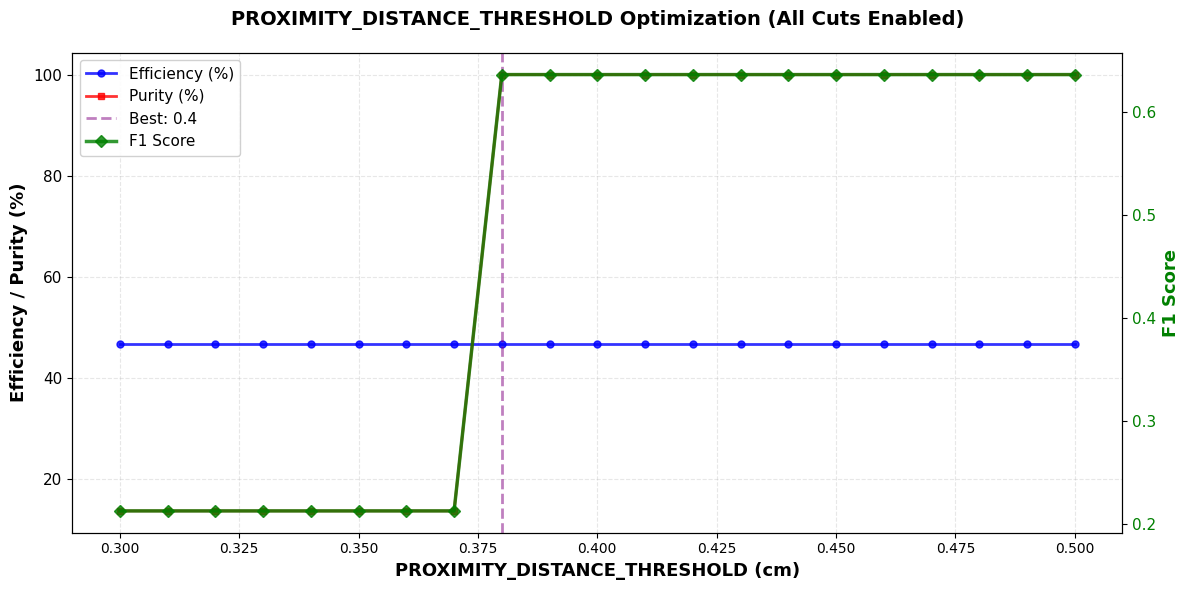


CURRENT PARAMETER VALUES (initial_params)
  MARGIN_MODULE                 : 0.43000000000000005
  MARGIN_DETECTOR               : 0.0
  ANGLE_CUT_MAX                 : 8.100000000000001
  DEDX_CUT_MIN                  : -99999
  DEDX_CUT_MAX                  : 2.62
  ETHETA2_CUT_MAX               : 5.779999999999983
  KE_CUT_MIN                    : 137.0
  PCA_TRANSVERSE_MAJOR_MIN      : 0.0
  PCA_TRANSVERSE_MINOR_MIN      : 0.0
  PROXIMITY_DISTANCE_THRESHOLD  : 0.38000000000000006 ← UPDATED


In [62]:
# Optimize PROXIMITY_DISTANCE_THRESHOLD with all other cuts enabled
param_name = 'PROXIMITY_DISTANCE_THRESHOLD'

# Custom range and step size
lower_bound = 0.30
upper_bound = 0.50
step_size = 0.01

# Enable ALL cuts
test_enable_flags = {
    'ENABLE_TOPOLOGY_CUT': True,
    'ENABLE_FIDUCIAL_CUT': True,
    'ENABLE_ANGLE_CUT': True,
    'ENABLE_DEDX_CUT': True,
    'ENABLE_ETHETA2_CUT': True,
    'ENABLE_KE_CUT': True,
    'ENABLE_PCA_CUT': True,
    'ENABLE_PROXIMITY_CUT': True,
}

# Use initial_params as base (initial guess for all other parameters)
test_params = initial_params.copy()

print("=" * 80)
print(f"Optimizing: {param_name} (with all other cuts enabled)")
print("=" * 80)
print(f"Range: [{lower_bound:.1f}, {upper_bound:.1f}], Step: {step_size:.1f}")
print(f"Initial value: {initial_params[param_name]:.1f}")
print("\nEnabled Cuts:")
for key, value in test_enable_flags.items():
    print(f"  {key}: {'✓' if value else '✗'}")
print("\nFixed Parameters (from initial_params):")
for key, value in initial_params.items():
    if key != param_name:
        print(f"  {key}: {value}")
print("=" * 80 + "\n")

import time
start_time = time.time()

# Generate test values
values = np.arange(lower_bound, upper_bound + step_size/2, step_size)
results = []

# Optimize with progress bar
for value in tqdm(values, desc=f"Scanning {param_name}"):
    test_params[param_name] = value
    
    efficiency, purity, f1, nuone_counts, fs_counts = calculate_efficiency_purity_f1(
        nuone_data, full_spill_data, test_params, test_enable_flags
    )
    
    background_count = fs_counts[1] - fs_counts[0]  # selected - true_1e_selected
    
    results.append({
        'value': value,
        'efficiency': efficiency,
        'eff_passed': nuone_counts[0],
        'eff_total': nuone_counts[1],
        'purity': purity,
        'background': background_count,
        'f1': f1
    })

elapsed = time.time() - start_time

# Output results in a table
print("\n" + "=" * 100)
print(f"OPTIMIZATION RESULTS: {param_name}")
print("=" * 100)
print(f"{'Value':>8s} | {'Efficiency':>20s} | {'Purity':>10s} | {'Background':>11s} | {'F1 Score':>10s}")
print("-" * 100)
for r in results:
    print(f"{r['value']:8.2f} | {r['efficiency']*100:6.2f}% ({r['eff_passed']:>4d}/{r['eff_total']:>4d}) | "
          f"{r['purity']*100:8.2f}% | {r['background']:>11d} | {r['f1']:10.4f}")

# Find best value
best_result = max(results, key=lambda x: x['f1'])
print("=" * 100)
print(f"⏱ Time: {elapsed:.1f}s")
print(f"\n✓ Best value: {best_result['value']:.2f}")
print(f"  Efficiency: {best_result['efficiency']*100:.2f}% ({best_result['eff_passed']}/{best_result['eff_total']})")
print(f"  Purity: {best_result['purity']*100:.2f}%")
print(f"  Background: {best_result['background']}")
print(f"  F1 Score: {best_result['f1']:.4f}")
print("=" * 100)

# Visualize results
fig, ax1 = plt.subplots(figsize=(12, 6))

param_values = [r['value'] for r in results]
efficiencies = [r['efficiency'] * 100 for r in results]
purities = [r['purity'] * 100 for r in results]
f1_scores = [r['f1'] for r in results]
backgrounds = [r['background'] for r in results]

# Plot Efficiency and Purity on left y-axis
ax1.plot(param_values, efficiencies, 'b-', linewidth=2, marker='o', markersize=5, 
         label='Efficiency (%)', alpha=0.8)
ax1.plot(param_values, purities, 'r-', linewidth=2, marker='s', markersize=5, 
         label='Purity (%)', alpha=0.8)
ax1.set_xlabel(f'{param_name} (cm)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Efficiency / Purity (%)', fontsize=13, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black', labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot F1 Score on right y-axis
ax2 = ax1.twinx()
ax2.plot(param_values, f1_scores, 'g-', linewidth=2.5, marker='D', markersize=6, 
         label='F1 Score', alpha=0.8)
ax2.set_ylabel('F1 Score', fontsize=13, fontweight='bold', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=11)

# Mark best value
ax1.axvline(best_result['value'], color='purple', linestyle='--', alpha=0.5, 
            linewidth=2, label=f"Best: {best_result['value']:.1f}")

plt.title(f'{param_name} Optimization (All Cuts Enabled)', fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

# Update initial_params with the optimized value
initial_params[param_name] = best_result['value']

# Print current parameters
print("\n" + "=" * 80)
print("CURRENT PARAMETER VALUES (initial_params)")
print("=" * 80)
for key, value in initial_params.items():
    marker = " ← UPDATED" if key == param_name else ""
    print(f"  {key:30s}: {value}{marker}")
print("=" * 80)

# Impact of Seperation Cut on Efficiency

In [72]:
# Test proximity cut impact on efficiency by embedding NuOne events into Full Spill events

import yaml
from spine.driver import Driver
from scipy.spatial import cKDTree
import random

# ==================== CONFIGURATION ====================
# Control parameters
NUM_NUONE_SAMPLES = 50      # Number of NuOne 1e events to test
NUM_FS_SAMPLES = 5          # Number of Full Spill events to use
VERBOSE = True              # Set to False to suppress detailed output
RANDOM_SEED = 42            # For reproducibility

# ========================================================

random.seed(RANDOM_SEED)

# First, filter NuOne events to get only true 1e events
nuone_1e_indices = [i for i in range(len(nuone_data['true_topology'])) 
                    if nuone_data['true_topology'][i] == '1e']

if VERBOSE:
    print("=" * 80)
    print("PROXIMITY CUT IMPACT TEST - BATCH MODE")
    print("=" * 80)
    print(f"\nConfiguration:")
    print(f"  NuOne 1e samples: {NUM_NUONE_SAMPLES}")
    print(f"  Full Spill samples: {NUM_FS_SAMPLES}")
    print(f"  Total combinations: {NUM_NUONE_SAMPLES * NUM_FS_SAMPLES}")
    print(f"  Verbose mode: {VERBOSE}")
    print(f"\nTotal NuOne events with true 1e topology: {len(nuone_1e_indices)}")

# Select random NuOne 1e events
selected_nuone_indices = random.sample(nuone_1e_indices, 
                                       min(NUM_NUONE_SAMPLES, len(nuone_1e_indices)))

# Select random Full Spill events
fs_event_ids_unique = list(set(full_spill_data['event_id']))
selected_fs_event_ids = random.sample(fs_event_ids_unique, 
                                     min(NUM_FS_SAMPLES, len(fs_event_ids_unique)))

if VERBOSE:
    print(f"\n✓ Selected {len(selected_nuone_indices)} NuOne 1e events")
    print(f"✓ Selected {len(selected_fs_event_ids)} Full Spill events")

cfg_template = '''
base:
  verbosity: info
build:
  mode: both
  fragments: false
  particles: true
  interactions: true
  units: cm
io:
  reader:
    file_keys: DATA_PATH
    name: hdf5
'''

# Cache Full Spill events to avoid reloading
if VERBOSE:
    print("\n📦 Loading Full Spill events...")
    
fs_event_cache = {}
for fs_event_id in tqdm(selected_fs_event_ids, desc="Loading FS events", disable=not VERBOSE):
    fs_file_number = str(fs_event_id)[:4]
    fs_file_path = f'/sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.000{fs_file_number}.LARCV_spine.h5'
    
    cfg_fs = cfg_template.replace('DATA_PATH', fs_file_path)
    driver_fs = Driver(yaml.safe_load(cfg_fs))
    
    fs_interactions = {}
    for data in driver_fs:
        if data['run_info'].event == fs_event_id:
            for reco, truth in data['interaction_matches_r2t']:
                all_points = []
                for particle in reco.particles:
                    if len(particle.points) > 0:
                        all_points.append(particle.points)
                if len(all_points) > 0:
                    fs_interactions[reco.id] = np.vstack(all_points)
            break
    
    fs_event_cache[fs_event_id] = fs_interactions

if VERBOSE:
    print(f"✓ Cached {len(fs_event_cache)} Full Spill events")

# Test each NuOne event embedded into each Full Spill event
if VERBOSE:
    print("\n🧪 Testing NuOne embeddings...")

results = []
for nuone_idx in tqdm(selected_nuone_indices, desc="Testing NuOne events", disable=not VERBOSE):
    nuone_event_id = nuone_data['event_id'][nuone_idx]
    nuone_reco_id = nuone_data['reco_id'][nuone_idx]
    
    # Load NuOne event
    nuone_file_number = str(nuone_event_id)[:3]
    nuone_file_path = f'/sdf/data/neutrino/ndlar/spine/prod/nuone/output_spine/MicroProdN3p2_NDLAr_2E22_FHC_NuE.flow2supera.ndlarfid.singles.0000{nuone_file_number}.LARCV_spine.h5'
    
    cfg_nuone = cfg_template.replace('DATA_PATH', nuone_file_path)
    driver_nuone = Driver(yaml.safe_load(cfg_nuone))
    
    nuone_points = None
    for data in driver_nuone:
        if data['run_info'].event == nuone_event_id:
            for reco, truth in data['interaction_matches_r2t']:
                if reco.id == nuone_reco_id:
                    all_points = []
                    for particle in reco.particles:
                        if len(particle.points) > 0:
                            all_points.append(particle.points)
                    if len(all_points) > 0:
                        nuone_points = np.vstack(all_points)
                    break
            break
    
    if nuone_points is None or len(nuone_points) == 0:
        if VERBOSE:
            print(f"⚠ Warning: NuOne event {nuone_event_id} has no points, skipping")
        continue
    
    # Build KDTree for NuOne event
    nuone_tree = cKDTree(nuone_points)
    
    # Test embedding into each Full Spill event
    for fs_event_id in selected_fs_event_ids:
        fs_interactions = fs_event_cache[fs_event_id]
        
        if len(fs_interactions) == 0:
            continue
        
        # Find minimum distance to any FS interaction
        min_distance = float('inf')
        closest_reco_id = None
        
        for reco_id, fs_points in fs_interactions.items():
            if len(fs_points) == 0:
                continue
            
            distances, _ = nuone_tree.query(fs_points, k=1)
            dist = np.min(distances)
            
            if dist < min_distance:
                min_distance = dist
                closest_reco_id = reco_id
        
        # Record result
        results.append({
            'nuone_idx': nuone_idx,
            'nuone_event_id': nuone_event_id,
            'nuone_reco_id': nuone_reco_id,
            'nuone_num_points': len(nuone_points),
            'fs_event_id': fs_event_id,
            'num_fs_interactions': len(fs_interactions),
            'min_distance': min_distance,
            'closest_reco_id': closest_reco_id
        })

if VERBOSE:
    print(f"\n✓ Completed {len(results)} embedding tests")

PROXIMITY CUT IMPACT TEST - BATCH MODE

Configuration:
  NuOne 1e samples: 50
  Full Spill samples: 5
  Total combinations: 250
  Verbose mode: True

Total NuOne events with true 1e topology: 6067

✓ Selected 50 NuOne 1e events
✓ Selected 5 Full Spill events

📦 Loading Full Spill events...


Loading FS events:   0%|          | 0/5 [00:00<?, ?it/s]


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfrome064 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {verbosity: info, world_size: 0, seed: 1765514700}
io:
  reader: {file_keys: /sdf/data/neutrino/ndlar/spine/prod/microprod_n4p1_v2/output_spine/MicroProdN4p1_NDComplex_FHC.flow2supera.full.0002540.LARCV_spine.h5,
    name: hdf5}
build: {mode: both, fragments: false, particles: true, interactions: true, units: cm}

Configuration processed at: Linux sdfrome064 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86

Testing NuOne events:   0%|          | 0/50 [00:00<?, ?it/s]


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfrome064 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {verbosity: info, world_size: 0, seed: 1765514712}
io:
  reader: {file_keys: /sdf/data/neutrino/ndlar/spine/prod/nuone/output_spine/MicroProdN3p2_NDLAr_2E22_FHC_NuE.flow2supera.ndlarfid.singles.0000248.LARCV_spine.h5,
    name: hdf5}
build: {mode: both, fragments: false, particles: true, interactions: true, units: cm}

Configuration processed at: Linux sdfrome064 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_6


RESULTS SUMMARY
Total tests: 250

Distance Statistics:
  Mean distance:   16.5772 cm
  Median distance: 12.8643 cm
  Std deviation:   14.4864 cm
  Min distance:    0.0000 cm
  Max distance:    95.2443 cm

EFFICIENCY IMPACT AT DIFFERENT THRESHOLDS
Threshold (cm)       | Pass Rate (%)   | Events Passing      
--------------------------------------------------------------------------------
0.10                 | 95.20           | 238/250
0.20                 | 95.20           | 238/250
0.30                 | 95.20           | 238/250
0.38                 | 92.80           | 232/250
0.50                 | 92.80           | 232/250
1.00                 | 91.20           | 228/250
2.00                 | 84.80           | 212/250
5.00                 | 74.80           | 187/250
10.00                | 58.40           | 146/250

At threshold (0.38 cm):
   Efficiency: 92.80%
   Efficiency loss:     7.20%
   Events passing:      232/250


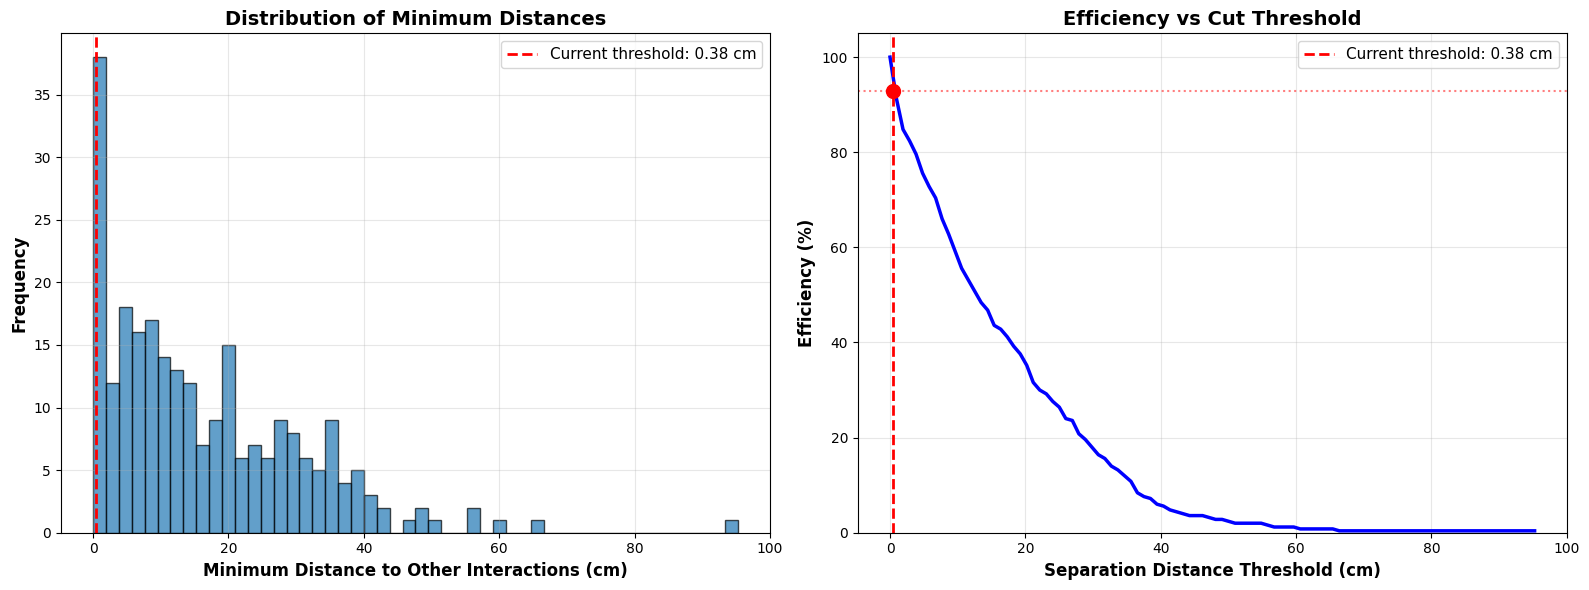


✓ Analysis complete!


In [76]:
# Analyze results
results_df = pd.DataFrame(results)

print("\n" + "=" * 80)
print("RESULTS SUMMARY")
print("=" * 80)
print(f"Total tests: {len(results_df)}")
print(f"\nDistance Statistics:")
print(f"  Mean distance:   {results_df['min_distance'].mean():.4f} cm")
print(f"  Median distance: {results_df['min_distance'].median():.4f} cm")
print(f"  Std deviation:   {results_df['min_distance'].std():.4f} cm")
print(f"  Min distance:    {results_df['min_distance'].min():.4f} cm")
print(f"  Max distance:    {results_df['min_distance'].max():.4f} cm")

# Calculate pass rate for different thresholds
print("\n" + "=" * 80)
print("EFFICIENCY IMPACT AT DIFFERENT THRESHOLDS")
print("=" * 80)
print(f"{'Threshold (cm)':<20} | {'Pass Rate (%)':<15} | {'Events Passing':<20}")
print("-" * 80)

test_thresholds = [0.1, 0.2, 0.3, 0.38, 0.5, 1.0, 2.0, 5.0, 10.0]
for threshold in test_thresholds:
    pass_count = sum(results_df['min_distance'] >= threshold)
    pass_rate = pass_count / len(results_df) * 100
    print(f"{threshold:<20.2f} | {pass_rate:<15.2f} | {pass_count}/{len(results_df)}")

print("=" * 80)
current_threshold = initial_params['PROXIMITY_DISTANCE_THRESHOLD']
pass_count_current = sum(results_df['min_distance'] >= current_threshold)
efficiency_retained = pass_count_current / len(results_df) * 100

print(f"\nAt threshold ({current_threshold:.2f} cm):")
print(f"   Efficiency: {efficiency_retained:.2f}%")
print(f"   Efficiency loss:     {100 - efficiency_retained:.2f}%")
print(f"   Events passing:      {pass_count_current}/{len(results_df)}")
print("=" * 80)

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of distances
ax1.hist(results_df['min_distance'], bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(current_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Current threshold: {current_threshold:.2f} cm')
ax1.set_xlabel('Minimum Distance to Other Interactions (cm)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Minimum Distances', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Efficiency curve
thresholds = np.linspace(0, results_df['min_distance'].max(), 100)
efficiency_curve = [sum(results_df['min_distance'] >= t) / len(results_df) * 100 for t in thresholds]

ax2.plot(thresholds, efficiency_curve, 'b-', linewidth=2.5)
ax2.axvline(current_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Current threshold: {current_threshold:.2f} cm')
ax2.axhline(efficiency_retained, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax2.scatter([current_threshold], [efficiency_retained], color='red', s=100, zorder=5)
ax2.set_xlabel('Separation Distance Threshold (cm)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Efficiency (%)', fontsize=12, fontweight='bold')
ax2.set_title('Efficiency vs Cut Threshold', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete!")